# 0. Importing packages

In [1]:
# importing packages to be used in the notebook
import numpy as np
import numba
from numba import njit
import warnings
import os
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import MultipleLocator

warnings.simplefilter('always', RuntimeWarning)

# plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
# plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'font.size': 15})
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 15}
plt.rc('font', **font)
plt.rc('text', usetex=True)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#006BA2','#DB444B','#000000','#EBB434',
                                                    '#3EBCD2','#379A8B','#9A607F', '#B4BA39', '#754C24']) 

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
from sequence_jacobian import interpolate
from sequence_jacobian import drawdag
from sequence_jacobian import JacobianDict
from scipy.interpolate import interp1d
from types import SimpleNamespace

# importing own modules
import hh_housing_v3 # contains the single EGM step 
import utils # contains different useful functions for the model

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

Defining standard things for the plots

In [88]:
devss = ['Y', 'qh', 'C_BHAT', 'w', 'N', 'Div', 'Tax'] # variables to plot in deviation from steady state

# Function to format y-axis labels with the same number of digits
def format_func(value, tick_number):
    return f'{value:.1f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

# 1. Creating model and finding steady state

Choose whether to use seperable or non-seperable preferences

In [81]:
seperable_pref = True

if seperable_pref:
    hh_name = 'hh_housecons_sep'
else:
    hh_name = 'hh_housecons'

## 1.1. Steady state model

In [82]:
# load the HA block
if seperable_pref:
    hh = hh_housing_v3.hh_housecons_sep
else:
    hh = hh_housing_v3.hh_housecons

# add hetinputs to the model
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])

if seperable_pref:
    blocks_ss = [hh1, utils.firm, utils.monetary, utils.fiscal, utils.wage_res_sep, utils.taylor_simple,
                utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime, utils.rotemberg_costs]
else: 
    blocks_ss = [hh1, utils.firm, utils.monetary, utils.fiscal, utils.wage_res, utils.taylor_simple,
                utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]    

hank_ss = create_model(blocks_ss, name="Housing HANK SS")

## 1.2. Transitional dynamics

In [ ]:
T = 300
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']
# exogenous = ['rstar', 'Z', 'gamma']

if seperable_pref:
    blocks = [hh1, utils.firm, utils.monetary, utils.fiscal, utils.wage_res_sep, utils.taylor_simple, 
            utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime, utils.rotemberg_costs]
else: 
    blocks = [hh1, utils.firm, utils.monetary, utils.fiscal, utils.wage_res, utils.taylor_simple,
            utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]

hank = create_model(blocks, name="Housing HANK")

## 1.3. Calibration and finding steady state

In [85]:
if seperable_pref:
    cali_main = {'gamma': 0.8, 'qh': 8.0, 'sigma': 1.0, 'alpha': 0.05, 'bmax': 45, 'rotemberg_cost': 0.0,
                'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0,
                'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
                'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}
    cali_main['rstar'] = 0.03/4
    # cali_main['theta'] = 0.054
    cali_main['gamma'] = 0.8
    cali_main['alpha'] = 0.0

    unknowns_ss = {'beta': 0.983, 'varphi': 0.833, 'theta': 0.05}
else:
    cali_main = {'gamma': 0.6, 'qh': 8.0, 'sigma': 1.0, 'alpha': 0.111, 'bmin': 0.0, 'bmax': 50,
                    'hmax': 5.0, 'kmax': 5.0, 'nB': 60, 'nH': 70, 'nK': 60, 'nZ': 3,
                    'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                    'kappa': 0.1, 'rstar': 0.005, 'phi': 1.25, 'nu': 1.0, 'BBAR': 0.25, 'G': 0.0, 'HBAR': 1.0}
    cali_main['gamma'] = 0.7
    cali_main['sigma'] = 2.0
    cali_main['alpha'] = 0.0
    cali_main['rstar'] = 0.03/4
    unknowns_ss = {'beta': 0.951, 'varphi': 0.809, 'theta': 0.97}

# unknowns_ss = {'beta': 0.983, 'varphi': 0.058, 'qh': 15.112}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss0 = hank_ss.solve_steady_state(cali_main, unknowns_ss, targets_ss, solver="hybr")

# Checking that the steady state DAG created above is valid
ss = hank.steady_state(ss0)
print(ss)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

<SteadyStateDict: ['beta', 'gamma', 'theta', 'sigma', 'qh', 'alpha', 'bmin', 'bmax', 'hmax', 'kmax', 'nB', 'nH', 'nK', 'nZ', 'rho_z', 'sigma_z', 'w', 'N', 'Z', 'pi', 'mu', 'kappa', 'BBAR', 'G', 'varphi', 'nu', 'rstar', 'phi', 'HBAR', 'gamma_p', 'qh_lag', 'i', 'r', 'Tax', 'Y', 'Div', 'H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI', 'asset_mkt', 'goods_mkt', 'house_mkt', 'wage_res', 'rotemberg_cost', 'nkpc_res'], internals=['hh_housecons_sep']>


In [86]:
print(f"beta: {ss0['beta']:.3f}, varphi: {ss0['varphi']:.3f}, qh: {ss0['qh']:.3f}, theta: {ss0['theta']:.3f}")

beta: 0.980, varphi: 0.833, qh: 8.000, theta: 0.062


In [108]:
hank_func, ss_func, T, unknowns, targets, Calibration = utils.model_setup()
_, mean_MPC = utils.calc_mpc(ss_func, hh_name)
print(f"Mean MPC: {mean_MPC:.3f}")

Mean MPC: 0.079


In [109]:
Calibration_new = Calibration.copy()
Calibration_new['qh'] = 10.0

hank_lg, ss_lg, _, _, _, _ = utils.model_setup(Calibration=Calibration_new)
_, mean_MPC = utils.calc_mpc(ss_lg, hh_name)
print(f"Mean MPC: {mean_MPC:.3f}")

Mean MPC: 0.063


In [128]:
exogenous = ['rstar']
G = hank_func.solve_jacobian(ss_func, unknowns, targets, exogenous, T=T)

rhos = np.array([0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95])
sig_r = 0.01
drstar = sig_r * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['pi']['rstar'] @ drstar
dy = G['Y']['rstar'] @ drstar
dqh = G['qh']['rstar'] @ drstar
dc = G['C_BHAT']['rstar'] @ drstar
dgoods = G['goods_mkt']['rstar'] @ drstar

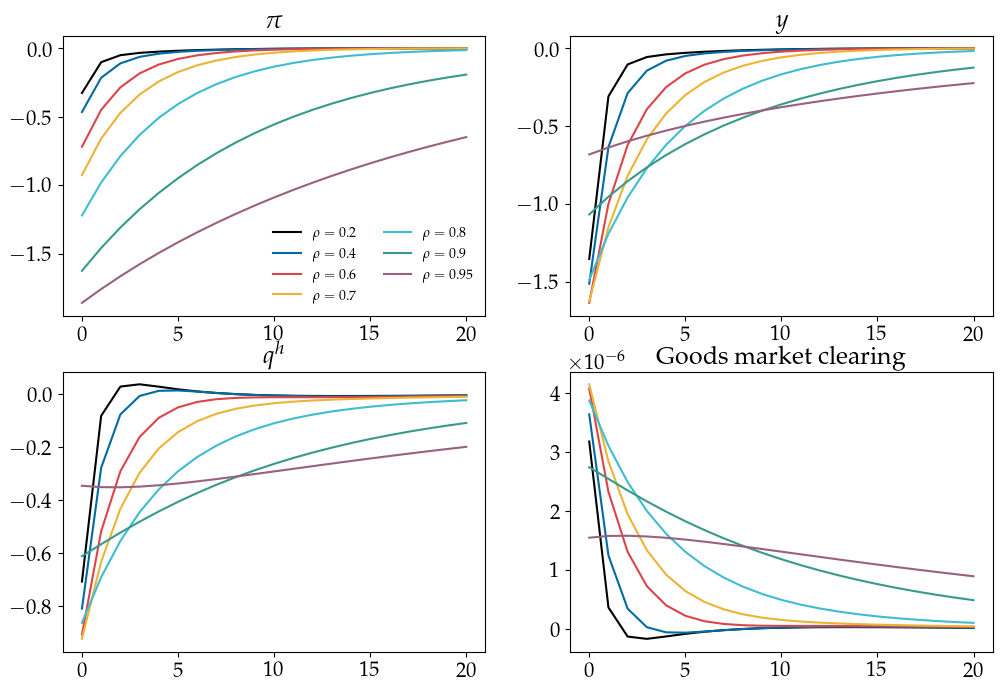

In [157]:
dqh_devss = (dqh) / ss_func['qh']
dy_devss = (dy) / ss_func['Y']
fig, ax = plt.subplots(2, 2, figsize=(18*2/3,8))
ax = ax.flatten()

ax[0].plot(100 * dpi[:21])
ax[0].set_title(r'$\pi$')
ax[0].legend([f'$\\rho = {rho}$' for rho in rhos], fontsize=10, ncols=2, frameon=False)
ax[1].plot(100 * dy_devss[:21])
ax[1].set_title(r'$y$')
ax[2].plot(100 * dqh_devss[:21])
# ax[2].plot(100 * dqh[:21])
ax[2].set_title(r'$q^h$')
ax[3].plot(dgoods[:21])
ax[3].set_title(r'Goods market clearing')
plt.show()

In [120]:
rho_r, sig_r = 0.95, 0.01
dr = sig_r * rho_r ** (np.arange(T))
dr_neg = -dr
rstar_shock = {"rstar": dr}
T = 300

irf = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock, verbose = False)
irf_func = hank_func.solve_impulse_linear(ss_func, unknowns, targets, rstar_shock, verbose = False)
irf_lg = hank_lg.solve_impulse_linear(ss_lg, unknowns, targets, rstar_shock, verbose = False)

KeyboardInterrupt: 

In [111]:
input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p']
output_list = ['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI', 'UCE_BHAT']

Js = {hh_name: hh1.jacobian(ss, inputs=input_list, outputs=output_list, T=T)}
print(hh1.name) # verify that 'hh_housecons_sep' is the name of the het-agent household block

combine_blocks = combine(blocks) 

irf_B = (combine_blocks.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                        Js=Js, inputs=['rstar'], outputs=['Y', 'C_BHAT', 'pi', 'r', 'i',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w']) @ {'rstar': dr})

hh_housecons_sep


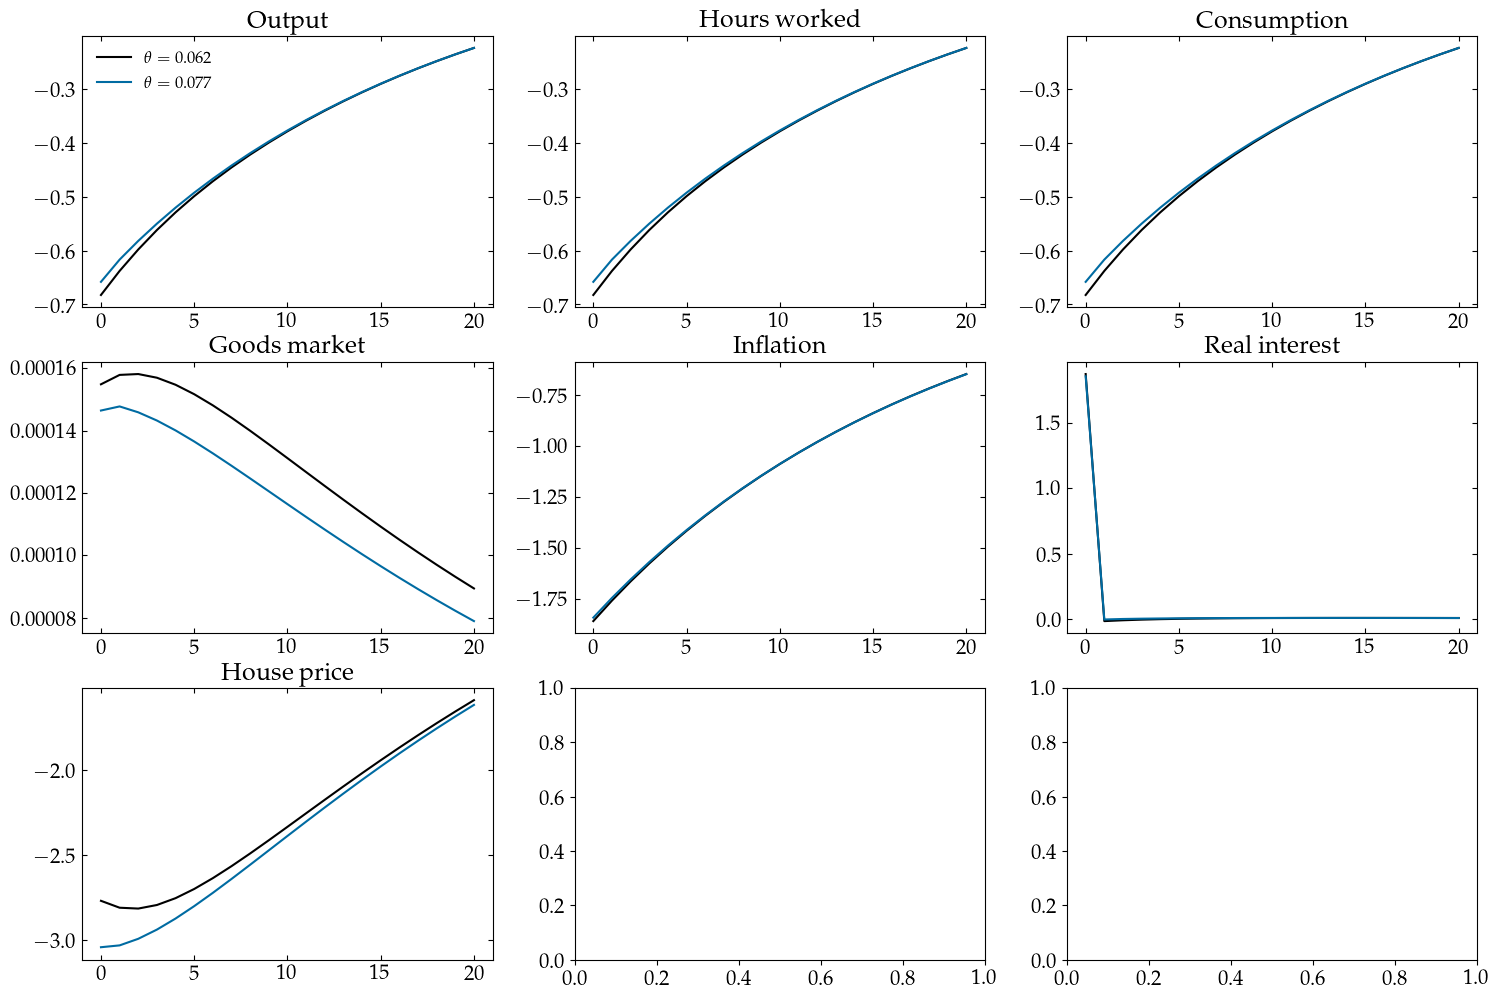

In [113]:
fig, ax = plt.subplots(3, 3, figsize=(18,12))
ax = ax.flatten()

var_name = {'Y': 'Output', 'N': 'Hours worked', 'C_BHAT': 'Consumption', 'goods_mkt': 'Goods market',
            'pi': 'Inflation', 'r': 'Real interest', 'qh': 'House price', 'N': 'Hours worked'}

for i, (key, value) in enumerate(var_name.items()):   
    # ax[i].plot(100*irf[key][:21], label = fr"$\theta = $ {ss['theta']:0.3f}")
    ax[i].plot(100*irf_func[key][:21], label = fr"$\theta =$ {ss_func['theta']:0.3f}")
    # ax[i].plot(100*irf_B[key][:21], label = fr"$\theta = $ {ss_func['theta']:0.3f}")
    ax[i].plot(100*irf_lg[key][:21], label = fr"$\theta = $ {ss_lg['theta']:0.3f}")
    ax[i].set_title(var_name[key])
    if i == 0:
        ax[i].legend(fontsize=12, frameon=False)
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)

plt.show()

# 2. Transitional dynamics after monetary policy shock

I start by defining the shocks that I want to study. The monetary policy shock is assumed to follow an AR(1) process $\epsilon_t=\rho \epsilon_{t-1}+\eta_t$ with persistence $\rho = 0.6$. In period $t=0$, the economy is hit by a 1-time unexpected (MIT) monetary policy shock of 100 bps. This is the same shock as in Hedlund et al. (2017).

In [15]:
rho_r, sig_r = 0.6, 0.01
dr = sig_r * rho_r ** (np.arange(T))
dr_neg = -dr
rstar_shock = {"rstar": dr}
T = 300

print(unknowns, targets)
ifr_main = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock, verbose = False)
# # # ifr_main_lin = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock, internals=[hh_name], verbose = False)
# ifr_main_neg = hank.solve_impulse_nonlinear(ss, unknowns, targets, {"rstar": dr_neg}, internals=['hh_housecons'])
# ifr_main_linear = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock, verbose = False)

['pi', 'w', 'N', 'qh'] ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']


## 2.1. Change in the distribution

In [ ]:
b_margdist_list = []
bmaragcum_list = []
for t in range(T):
    bdmargdist = np.sum(ss.internals[hh_name]['D'] + ifr_main.internals[hh_name]['D'][t], axis=0)
    b_margdist_list.append(np.sum(bdmargdist,axis=1))  # sum out housing
    bmaragcum_list.append(np.cumsum(b_margdist_list[t], axis=0))

# b_margdist_neg_list = []
# bmaragcum_neg_list = []
# for t in range(T):
#     bdmargdist = np.sum(ss.internals['hh_housecons']['D'] + ifr_main_neg.internals['hh_housecons']['D'][t], axis=0)
#     b_margdist_neg_list.append(np.sum(bdmargdist,axis=1))  # sum out housing
#     bmaragcum_neg_list.append(np.cumsum(b_margdist_list[t], axis=0))

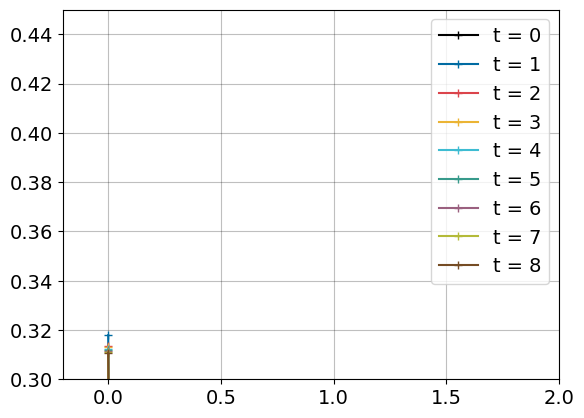

In [ ]:
for t in range(T - 291):
    plt.plot(ss.internals[hh_name]['b_bhat_grid'], b_margdist_list[t], marker = '+', label=f't = {t}')
    # plt.plot(ss.internals['hh_housecons']['b_bhat_grid'], b_margdist_neg_list[t], marker = 'x', ls = ':', label=f't = {t}')

plt.xlim(-0.2, 2)
plt.ylim(0.3, 0.45)
# plt.ylim(0.5, 0.525)
plt.legend()

## 2.1. Plotting IRFs and more

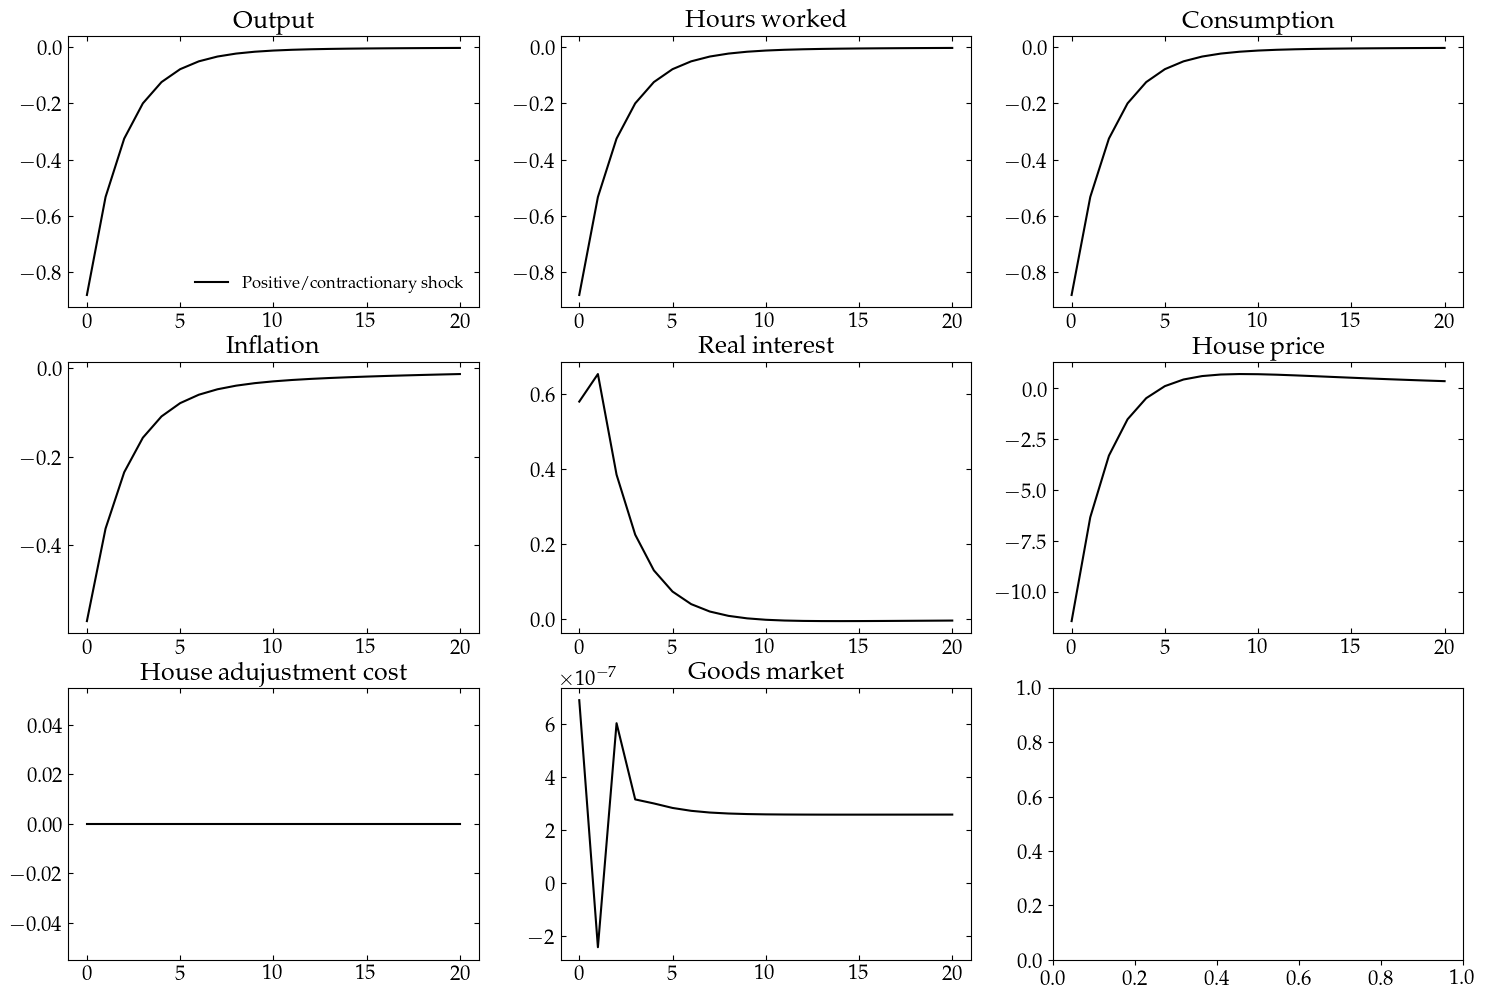

0.7047859809568687


In [17]:
fig, ax = plt.subplots(3, 3, figsize=(18,12))
ax = ax.flatten()

var_name = {'Y': 'Output', 'N': 'Hours worked', 'C_BHAT': 'Consumption', 
            'pi': 'Inflation', 'r': 'Real interest', 'qh': 'House price', 'CHI': 'House adujustment cost',
            'goods_mkt': 'Goods market', 'N': 'Hours worked'}

for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*ifr_main[key][:21])
    # ax[i].plot(-100*ifr_main_neg[key][:21])
    # ax[i].plot(100*ifr_main_linear[key][:21])
    ax[i].set_title(var_name[key])
    if i == 0:
        ax[i].legend(['Positive/contractionary  shock', 'Negative/expansionary (mirror)'], fontsize=12, frameon=False)
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)

plt.show()
print(100*np.max(ifr_main['qh'][1:21]))

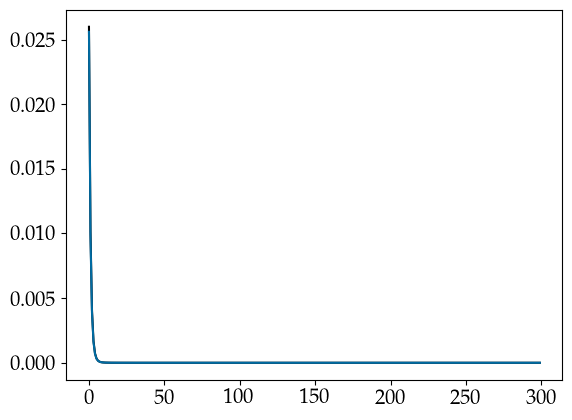

In [414]:
plt.plot(100*(ifr_main['C_BHAT'] + ifr_main['rotemberg_cost'] - ifr_main['Y']), label='C')
plt.plot(100*(ifr_main_neg['C_BHAT'] + ifr_main_neg['rotemberg_cost'] - ifr_main_neg['Y']), label='C')
# plt.plot(100*(ss['Y'] + ifr_main['Y'] - ifr_main['C_BHAT'] - ss['C_BHAT']))

# plt.plot(100*(ifr_main_neg['Y'] - ifr_main_neg['C_BHAT']))
# adjust_cost = 100*ss['mu']/(ss['mu']-1)/(2*ss['kappa']) * np.log(1+ifr_main['pi'])**2*(ss['Y'] + ifr_main['Y'])
# adjust_cost_neg = 100*ss['mu']/(ss['mu']-1)/(2*ss['kappa']) * np.log(1+ifr_main_neg['pi'])**2*(ss['Y'] + ifr_main_neg['Y'])
# plt.plot(adjust_cost)
# plt.plot(adjust_cost_neg)

# # goodsmkt = ifr_main['goods_mkt']

# # print(np.mean(goodsmkt), np.mean(goodsmkt))

# 3. Getting hump-shaped IRFs

In [158]:
from numba import njit
@njit
def manipulate_separable(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

def E_sticky_exp(theta, T=T, sticky_info=False):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    if sticky_info:
        return E
    else:
        E = np.triu(E, +1) + np.tril(np.ones((T, T)))
        return E

In [159]:
from sequence_jacobian import JacobianDict
import scipy

# rho_r, sig_r = 0.95, 0.01
rho_r, sig_r = 0.8, 0.01
dr = sig_r * rho_r ** (np.arange(T))
xi = 0.95

# hank.solve_impulse_nonlinear_options

input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p']
output_list = ['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI', 'UCE_BHAT']

Js = {hh_name: hh1.jacobian(ss, inputs=input_list, outputs=output_list, T=T)}
print(hh1.name) # verify that 'hh_housecons_sep' is the name of the het-agent household block

jac_ = {}
for output in output_list:
    jac_[output] = {}
    for input in input_list:
        jac_[output][input] = manipulate_separable(Js[hh_name][output][input], E_sticky_exp(xi))

Js_myopic = {hh_name: JacobianDict(jac_, inputs=input_list, outputs=output_list, name='hh1')}

combine_blocks = combine(blocks) 
Js_myopic = {hh_name: JacobianDict(jac_, inputs=input_list, 
                                   outputs=output_list, name='hank')}

irf_B_myopic = (combine_blocks.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                              Js=Js_myopic, inputs=['rstar'], 
                                              outputs=['Y', 'C_BHAT', 'pi', 'r', 'i',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w']) @ {'rstar': dr})

irf_B = (combine_blocks.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                        Js=Js, inputs=['rstar'], outputs=['Y', 'C_BHAT', 'pi', 'r', 'i',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w']) @ {'rstar': dr})

# irf_hump = combine_blocks.solve_impulse_linear(ss, unknowns, targets, inputs={'rstar': dr}, Js = Js_myopic, internals=[hh_name])
# irf_hump_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, {'rstar': dr}, 
#                                                internals=[hh_name], verbose = True, Js = Js, maxit = 30)
# irf_hump_nonlin_myopic = combine_blocks.solve_impulse_nonlinear(ss, unknowns, targets, {'rstar': dr}, 
#                                                internals=[hh_name], verbose = True, Js = Js_myopic, maxit = 200)                                               

hh_housecons_sep


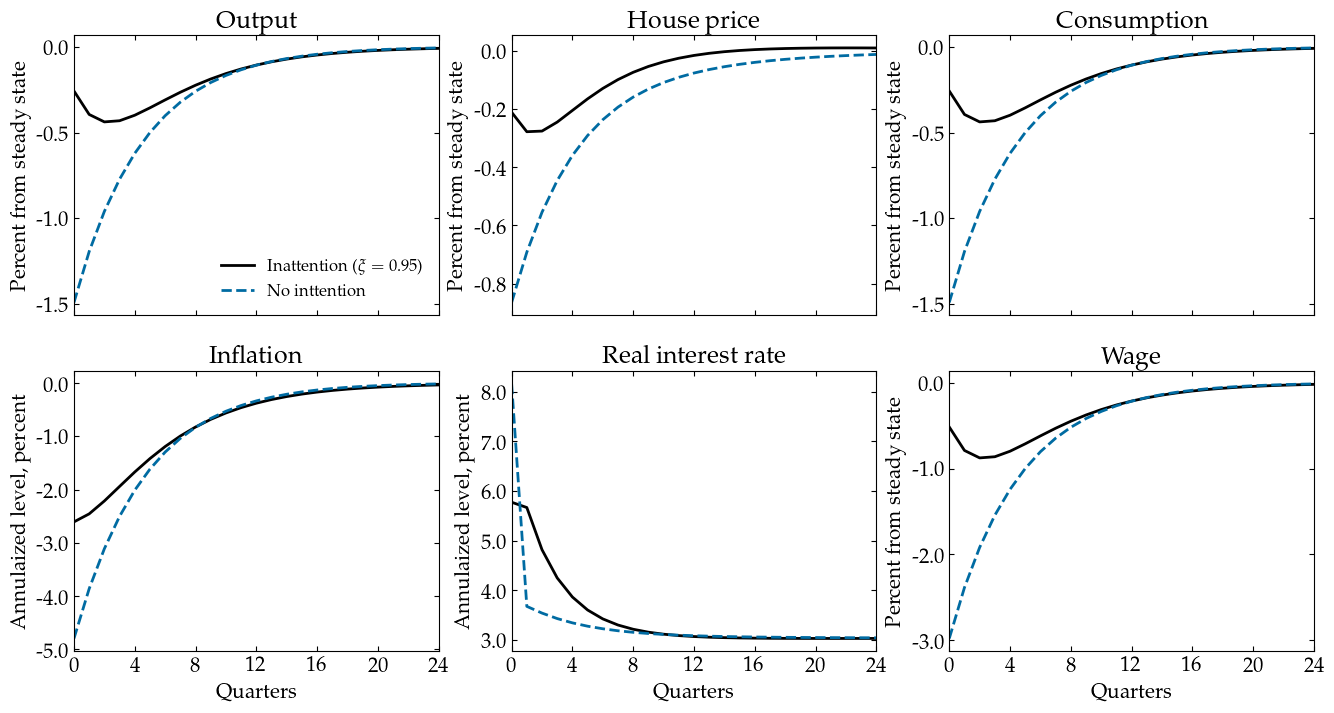

In [ ]:
# import os
fig, ax = plt.subplots(2, 3, figsize=(16,8), sharex=True)
ax = ax.flatten()

var_name = {'Y': 'Output', 'qh': 'House price', 'C_BHAT': 'Consumption', 'pi': 'Inflation', 
            'r': 'Real interest rate', 'w': 'Wage'}

devss = ['Y', 'qh', 'C_BHAT', 'w']

# Function to format y-axis labels with the same number of digits
def format_func(value, tick_number):
    return f'{value:.1f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

H = 25
interval = 8
# for i, var in enumerate(var_plot):
for i, (key, value) in enumerate(var_name.items()):
    if key in devss:   
        ax[i].plot(100*(irf_B_myopic[key][:H]/ss[key]), linewidth=2)
        ax[i].plot(100*(irf_B[key][:H]/ss[key]), ls = '--', linewidth=2)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + ss[key] +irf_B_myopic[key][:H])**4-1), linewidth=2)
        ax[i].plot(100*((1 + ss[key] +irf_B[key][:H])**4-1), ls = '--', linewidth=2)
        ax[i].set_ylabel('Annulaized level, percent')
    # ax[i].plot(100*irf_hump[key][:H])
    # ax[i].plot(100*irf_hump_nonlin[key][:H])
    # ax[i].plot(100*irf_hump_nonlin_myopic[key][:H])
    ax[i].set_title(var_name[key])
    ax[i].set_xlim(0, H -1)
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    # ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0, label='Horizontal Line')

    if i == 0:
        ax[i].legend([fr'Inattention ($\xi =$ {xi})', 'No inttention'], fontsize=12, frameon=False)
        # ax[i].set_ylabel('\% deviation from steady state')
    elif i == 3:
        pass
        # ax[i].set_ylabel('\% deviation from steady state')

    if i == 3 or i == 4 or i == 5:
        ax[i].set_xlabel('Quarters')
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"

    # Save the plot
    fig.savefig(os.path.join(figure_path, 'Baseline mp shock.pdf'), dpi=1000, bbox_inches='tight')

## X.x. Decomposing the response by group

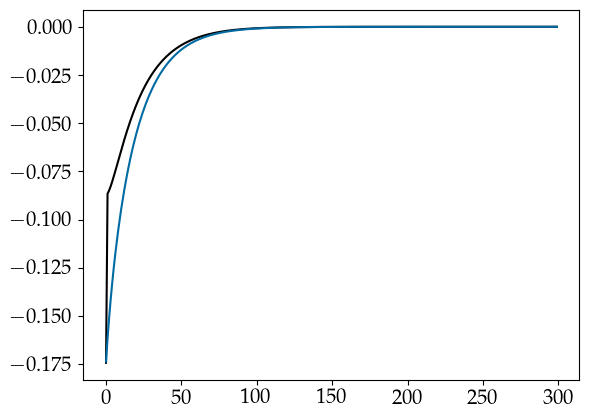

In [50]:
irf_hump_nonlin.internals[hh_name]['c_bhat']
dC_low = 100*np.sum(irf_hump_nonlin.internals[hh_name]['c_bhat']*(ss.internals[hh_name]['Dbeg'] + irf_hump_nonlin.internals[hh_name]['D']), axis = (1,2,3)) 

plt.plot(dC_low)
plt.plot(100*irf_hump_nonlin['C_BHAT'])

In [59]:
from sequence_jacobian.utilities.optimized_routines import fast_aggregate

print(irf_hump_nonlin.internals[hh_name]['D'].shape, irf_hump_nonlin.internals[hh_name]['c_bhat'].shape)
C_BHAT = fast_aggregate(ss.internals[hh_name]['D'] + irf_hump_nonlin.internals[hh_name]['D'],irf_hump_nonlin.internals[hh_name]['c_bhat'])

(300, 3, 50, 70) (300, 3, 50, 70)


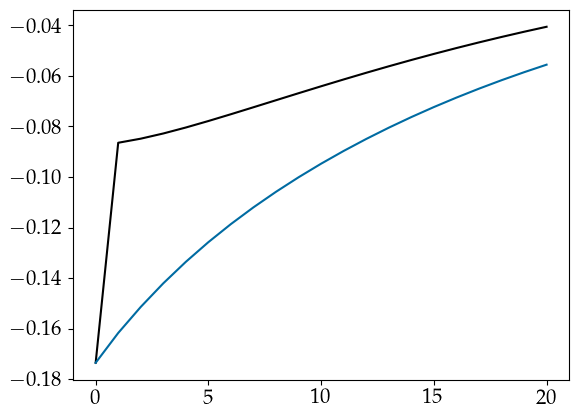

In [62]:
plt.plot(100*C_BHAT[:21])
plt.plot(100*irf_hump_nonlin['C_BHAT'][:21])

In [23]:
import pandas as pd
import os

# Define the path to the Excel file
subfolder = 'Misc'
filename = 'rrshockirfs_v2.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)

# Load the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name='gamma', header = None)

# col_name = ['r', 'C_BHAT', 'qh', 'Y', 'pi', 'SPX', 'unemp']
col_name = ['r', 'C_BHAT', 'qh', 'Y', 'pi', 'N', 'Investment', 'w', 'Mortgage']
df.columns = col_name

df_bands = pd.read_excel(file_path, sheet_name='gammabands', header = None)

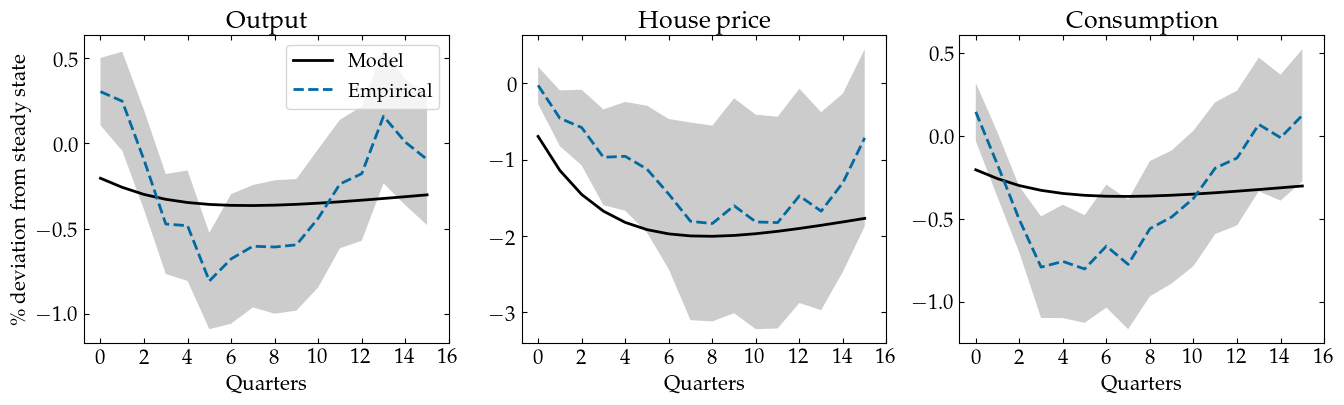

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(16,4), sharex=True)
ax = ax.flatten()

var_name = {'Y': 'Output', 'qh': 'House price', 'C_BHAT': 'Consumption'}

H = 16
interval = 2
# for i, var in enumerate(var_plot):
for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*irf_B_myopic[key][:H], linewidth=2)

    if key == 'qh' or key == 'C_BHAT' or key == 'Y':
        ax[i].plot(100*df[key][:H], ls = '--', linewidth=2)

    if key == 'qh':
        ax[i].fill_between(range(H), 100*df_bands[2][:H], 100*df_bands[2 + 9][:H], alpha = 0.2)

    if key == 'C_BHAT':
        ax[i].fill_between(range(H), 100*df_bands[1][:H], 100*df_bands[1 + 9][:H], alpha = 0.2)

    if key == 'Y':
        ax[i].fill_between(range(H), 100*df_bands[3][:H], 100*df_bands[3 + 9][:H], alpha = 0.2)
        
    ax[i].set_title(var_name[key])
    ax[i].set_xticks(range(0, H + 1, interval))
    ax[i].set_xticklabels(range(0, H + 1, interval))
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    
    if i == 0:
        ax[i].legend(['Model', r'Empirical'], fontsize=14)
        ax[i].set_ylabel('\% deviation from steady state')
    elif i == 3:
        ax[i].set_ylabel('\% deviation from steady state')

    if i == 0 or i == 1 or i == 2:
        ax[i].set_xlabel('Quarters')
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"

    # Save the plot
    fig.savefig(os.path.join(figure_path, 'Empirical comparsion.pdf'), dpi=1000, bbox_inches='tight')

In [78]:
# empty namespace to store decompositions
decomp = SimpleNamespace()
decomp.myopic = SimpleNamespace()
decomp.attention = SimpleNamespace()

# empty namespace to store irfs
irf = SimpleNamespace()
irf.lowleverage = SimpleNamespace()
irf.highleverage = SimpleNamespace()

input_list_decomp = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w']
for k in input_list_decomp:
    setattr(decomp.myopic, f'dC_d{k}', Js_myopic['hh_housecons_sep']['C_BHAT'][k] @ irf_B_myopic[k])
    setattr(decomp.attention, f'dC_d{k}', Js['hh_housecons_sep']['C_BHAT'][k] @ irf_B[k])

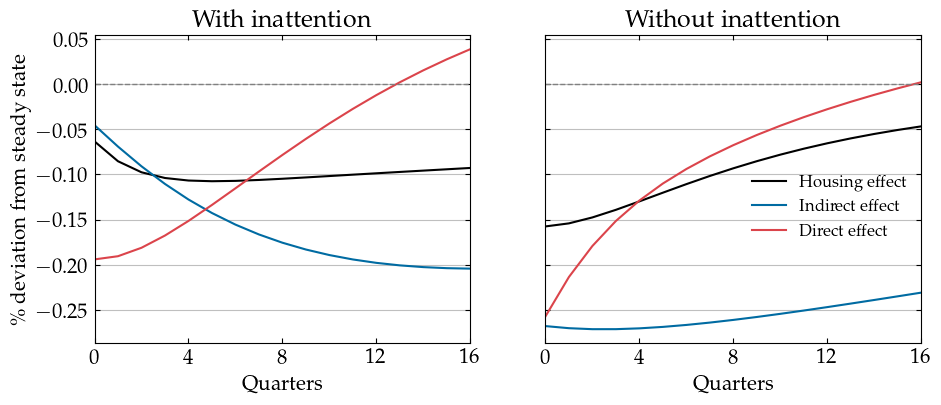

In [ ]:
decomp_dict_ll = vars(decomp.myopic)
decomp_dict_hl = vars(decomp.attention)

total_response_ll = 0
total_response_hl = 0

for (key, value) in decomp_dict_ll.items():
    total_response_ll += value

for (key, value) in decomp_dict_hl.items():
    total_response_hl += value

housing_effect_ll = decomp.myopic.dC_dqh + decomp.myopic.dC_dqh_lag
housing_effect_hl = decomp.attention.dC_dqh + decomp.attention.dC_dqh_lag
indirect_effect_ll = decomp.myopic.dC_dN + decomp.myopic.dC_dTax + decomp.myopic.dC_dDiv + decomp.myopic.dC_dw
indirect_effect_hl = decomp.attention.dC_dN + decomp.attention.dC_dTax + decomp.attention.dC_dDiv + decomp.attention.dC_dw
direct_effect_ll = decomp.myopic.dC_dr
direct_effect_hl = decomp.attention.dC_dr

fig, ax = plt.subplots(1, 2, figsize=(16*2/3,4), sharey=True)
ax = ax.flatten()
H = 17
interval = 2

ii = 0
ax[ii].plot(100*housing_effect_ll[:H], label='Housing effect')
ax[ii].plot(100*indirect_effect_ll[:H], label='Indirect effect')
ax[ii].plot(100*direct_effect_ll[:H], label='Direct effect')
ax[ii].set_title('With inattention')
ax[ii].set_xlabel('Quarters')
ax[ii].set_ylabel('\% deviation from steady state')
# ax[ii].set_xticks(range(0, H + 1, interval))
# ax[ii].set_xticklabels(range(0, H + 1, interval))
ax[ii].xaxis.set_major_locator(MultipleLocator(4))
ax[ii].set_xlim(0, 16)
ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax[ii].grid(True, axis='y', color='black', alpha=0.25, linestyle='-')

ii += 1
ax[ii].plot(100*housing_effect_hl[:H], label='Housing effect')
ax[ii].plot(100*indirect_effect_hl[:H], label='Indirect effect')
ax[ii].plot(100*direct_effect_hl[:H], label='Direct effect')
ax[ii].set_title('Without inattention')
ax[ii].set_xlabel('Quarters')
ax[ii].set_xlim(0, 16)
ax[ii].xaxis.set_major_locator(MultipleLocator(4))
ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax[ii].legend(fontsize=12, frameon=False, loc='center right', bbox_to_anchor=(1, 0.44))
ax[ii].grid(True, axis='y', color='black', alpha=0.25, linestyle='-')

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"

    # Save the plot
    fig.savefig(os.path.join(figure_path, 'Consumption Decomposition.pdf'), dpi=1000, bbox_inches='tight')

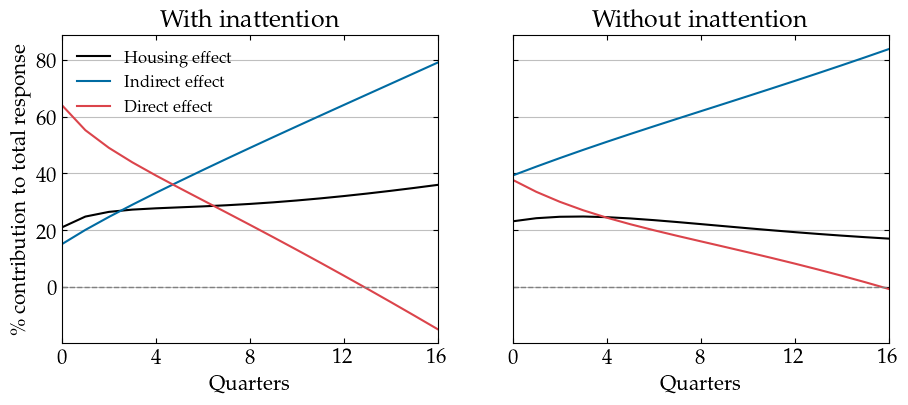

In [115]:
qh_cons_mynopic = housing_effect_ll / total_response_ll
qh_cons_attention = housing_effect_hl / total_response_hl
indirect_cons_mynopic = indirect_effect_ll / total_response_ll
indirect_cons_attention = indirect_effect_hl / total_response_hl
direct_cons_mynopic = direct_effect_ll / total_response_ll
direct_cons_attention = direct_effect_hl / total_response_hl

fig, ax = plt.subplots(1, 2, figsize=(16*2/3,4), sharex=True, sharey=True)
ax = ax.flatten()
H = 17
interval = 2

ii = 0
ax[ii].plot(100*qh_cons_mynopic[:H], label='Housing effect')
ax[ii].plot(100*indirect_cons_mynopic[:H], label='Indirect effect')
ax[ii].plot(100*direct_cons_mynopic[:H], label='Direct effect')
# ax[ii].plot(100*(direct_cons_mynopic[:H] + qh_cons_mynopic[:H] + indirect_cons_mynopic[:H]), label='Total (for check)')
ax[ii].set_title('With inattention')
ax[ii].set_xlabel('Quarters')
ax[ii].set_ylabel('\% contribution to total response')
ax[ii].xaxis.set_major_locator(MultipleLocator(4))
ax[ii].set_xlim(0, 16)
ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax[ii].legend(fontsize=12, frameon=False)
ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax[ii].grid(True, axis='y', color='black', alpha=0.25, linestyle='-')

ii += 1
ax[ii].plot(100*qh_cons_attention[:H], label='Housing effect')
ax[ii].plot(100*indirect_cons_attention[:H], label='Indirect effect')
ax[ii].plot(100*direct_cons_attention[:H], label='Direct effect')
# ax[ii].plot(100*(direct_cons_attention[:H] + qh_cons_attention[:H] + indirect_cons_attention[:H]), label='Total (for check)')
ax[ii].set_title('Without inattention')
ax[ii].set_xlabel('Quarters')
ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax[ii].grid(True, axis='y', color='black', alpha=0.25, linestyle='-')

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"

    # Save the plot
    fig.savefig(os.path.join(figure_path, 'Percent contribution.pdf'), dpi=1000, bbox_inches='tight')

In [ ]:
plt.plot(Js_myopic['hh_housecons_sep']['C_BHAT']['r'][10])
plt.plot(Js['hh_housecons_sep']['C_BHAT']['r'][10])

In [ ]:
rho_r, sig_r = 0.6, 0.01/4
dr = sig_r * rho_r ** (np.arange(T))
rstar_shock = {"rstar": dr}

irf_B_myopic = (hank.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                        Js=Js_myopic, inputs=['rstar'], outputs=['Y']) @ {'rstar': dr})['Y']

irf_B = (hank.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                        Js=Js, inputs=['rstar'], outputs=['Y']) @ {'rstar': dr})['Y']

irf_myopic = (hank.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                        Js=Js_myopic, inputs=['rstar'], outputs=['Y']) @ rstar_shock)

# 4. Inertial Taylor Rule

In [128]:
seperable_pref = True
# load the HA block
if seperable_pref:
    hh = hh_housing_v3.hh_housecons_sep
    hh_name = hh.name
else:
    hh = hh_housing_v3.hh_housecons
    hh_name = hh.name

# add hetinputs to the model
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])

if seperable_pref:
    blocks_ss = [hh1, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
                utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]
else: 
    blocks_ss = [hh1, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res,
                utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]    
hank_ss = create_model(blocks_ss, name="Housing HANK SS")

T = 300
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']
exogenous = ['rstar', 'Z', 'gamma']

if seperable_pref:
    blocks = [hh1, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
                utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]
else:
    blocks = [hh1, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res,
                utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]
hank = create_model(blocks, name="Housing HANK")

In [130]:
if seperable_pref:
    cali_main = {'gamma': 0.8, 'qh': 8.0, 'sigma': 1.0, 'alpha': 0.05, 'bmax': 45, 'rhom': 0.9,
                'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'epsm': 0.0,
                'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
                'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}
    cali_main['rstar'] = 0.03/4
    # cali_main['theta'] = 0.054
    cali_main['gamma'] = 0.8
    cali_main['alpha'] = 0.1
    cali_main['sigma'] = 2.0

    unknowns_ss = {'beta': 0.983, 'varphi': 0.833, 'theta': 0.05}
else:
    cali_main = {'gamma': 0.6, 'qh': 8.0, 'sigma': 2.0, 'alpha': 0.111, 'bmin': 0.0, 'bmax': 50,
                    'hmax': 5.0, 'kmax': 5.0, 'nB': 60, 'nH': 70, 'nK': 60, 'nZ': 3, 'rhom': 0.9, 'epsm': 0.0,
                    'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                    'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.25, 'G': 0.0, 'HBAR': 1.0}
    cali_main['gamma'] = 0.8
    cali_main['sigma'] = 2.0
    cali_main['alpha'] = 0.0
    cali_main['rstar'] = 0.03/4
    unknowns_ss = {'beta': 0.959, 'varphi': 0.783, 'theta': 0.939}

targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}
ss0 = hank_ss.solve_steady_state(cali_main, unknowns_ss, targets_ss, solver="hybr")
ss = hank.steady_state(ss0)
print(f"beta: {ss0['beta']:.3f}, varphi: {ss0['varphi']:.3f}, qh: {ss0['qh']:.3f}, theta: {ss0['theta']:.3f}")

do_highwealth = False
if do_highwealth:
    # cali_lowr = {'gamma': 0.8, 'theta': 0.941, 'sigma': 2.0, 'alpha': 0.00, 'bmin': 0.0, 'bmax': 50,
    #                 'hmax': 5.0, 'kmax': 5.0, 'nB': 60, 'nH': 70, 'nK': 60, 'nZ': 3, 'rhom': 0.9, 'epsm': 0.0,
    #                 'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
    #                 'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.25, 'G': 0.0, 'HBAR': 1.0}
    # # cali_lowr['rstar'] = 0.005
    # unknowns_ss = {'beta': 0.962, 'varphi': 0.800, 'qh': 8.000}

    cali_lowr = cali_main.copy()
    cali_lowr['qh'] = 16.0

    unknowns_ss = {'beta': 0.983, 'varphi': 0.833, 'theta': 0.05}

    ss0 = hank_ss.solve_steady_state(cali_lowr, unknowns_ss, targets_ss, solver="hybr")
    ss_lowr = hank.steady_state(ss0)
    print(f"beta: {ss0['beta']:.3f}, varphi: {ss0['varphi']:.3f}, qh: {ss0['qh']:.3f}, theta: {ss0['theta']:.3f}")

beta: 0.959, varphi: 0.834, qh: 8.000, theta: 0.065


### Housing wealth elasticity

In [62]:
TT = 400
sigma_qh = ss['qh']*0.01
rho_qh = 0.9
qh = sigma_qh*rho_qh** np.arange(TT)
qh_lag = np.zeros(TT)

for i in range(1, TT):
    qh_lag[i] = qh[i-1]

qh_nonlinear = hh1.impulse_linear(ss, {'qh': qh, 'qh_lag': qh_lag}, outputs = ['C_BHAT'],internals=['hh_housecons'])
percent_c = 100*qh_nonlinear['C_BHAT']/ss['C_BHAT']
percent_qh = 100*qh/ss['qh']

###################################################
sigma_qh = ss_lowr['qh']*0.01
qh = sigma_qh*rho_qh** np.arange(TT)
qh_lag = np.zeros(TT)

for i in range(1, TT):
    qh_lag[i] = qh[i-1]

qh_highqh_nonlinear = hh1.impulse_linear(ss, {'qh': qh, 'qh_lag': qh_lag}, Js=Js_myopic,
                                         outputs = ['C_BHAT'],internals=['hh_housecons'],
                                         )

percent_c_highqh = 100*qh_highqh_nonlinear['C_BHAT']/ss_lowr['C_BHAT']
percent_qh_highqh = 100*qh/ss_lowr['qh']

elasticity = percent_c/percent_qh[0]
elasticity_highqh = percent_c_highqh/percent_qh_highqh[0]

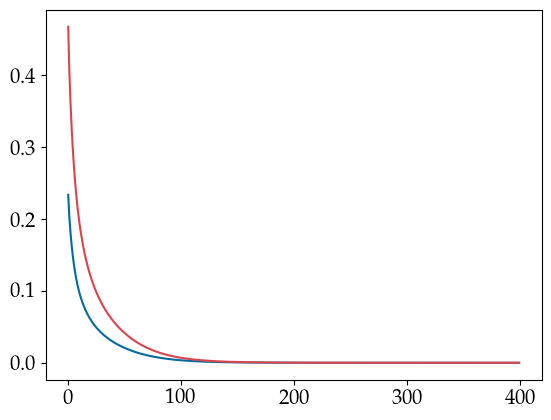

In [63]:
# plt.plot(partialeq_irf['C_BHAT'] + partialeq_irflag['C_BHAT'])
plt.plot(elasticity)
plt.plot(elasticity_highqh)
# plt.xlim(0, 20)
# plt.ylim(0, 2)
# plt.plot(percent_qh)

### Steady state distribution

Text(0.5, 0.5, '$h$')

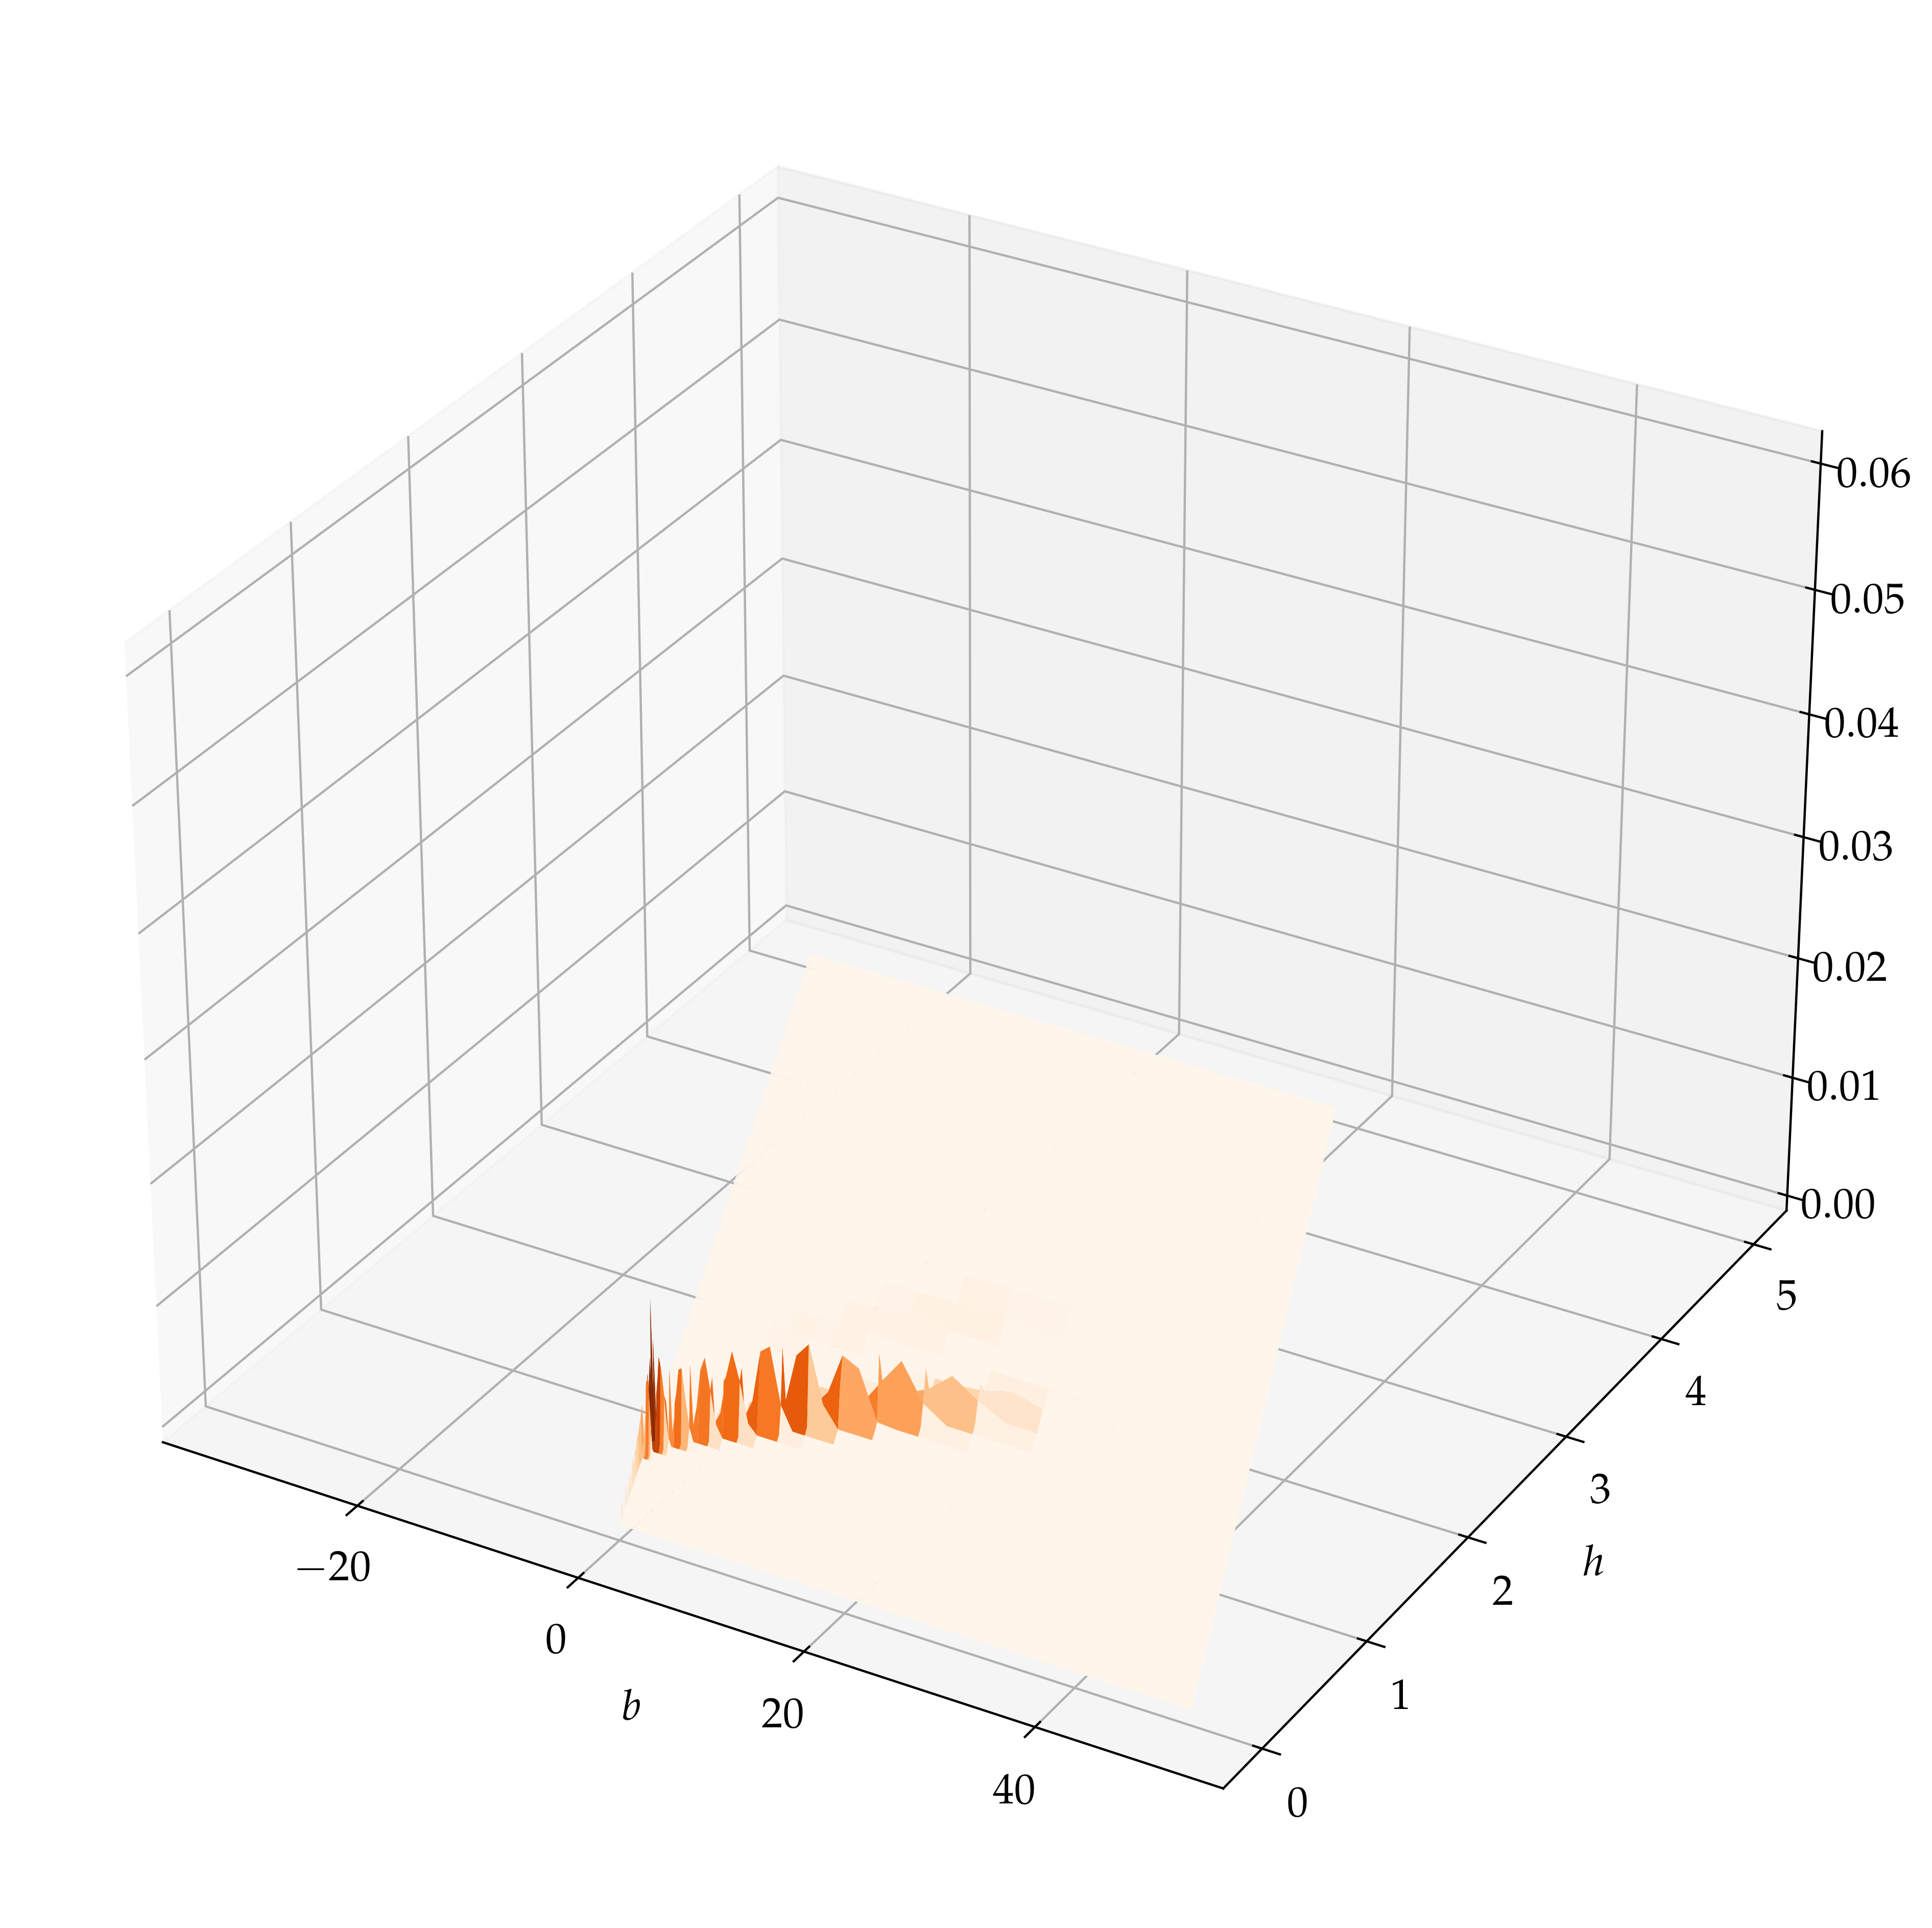

In [248]:
from mpl_toolkits.mplot3d import Axes3D
XX, YY = np.meshgrid(ss.internals[hh_name]['h_bhat_grid'],ss.internals[hh_name]['b_bhat_grid'])
b_endo = ss.internals[hh_name]['b_bhat_grid'][:,None] \
            - ss['qh_lag']*ss['gamma']*ss.internals[hh_name]['h_bhat_grid'][None,:]

ss.internals[hh_name]['D'].shape
leverage = b_endo/(ss['qh']*ss.internals[hh_name]['h_bhat_grid'])

fig = plt.figure(figsize=(12, 12), dpi=400)
ax = fig.add_subplot(111, projection='3d')
surf2 = ax.plot_surface(b_endo, XX, ss.internals['hh_housecons']['D'][1,:,:], cmap='Oranges', alpha=1.0, label = ' z = 0')
ax.set_xlabel('$b$')
ax.set_ylabel('$h$')

In [257]:
print(np.max(b_endo))
print(b_endo.shape)
print(ss['qh']*ss.internals[hh_name]['h_bhat_grid'])

leverage = b_endo/(ss['qh']*ss.internals[hh_name]['h_bhat_grid'][np.newaxis,:])
print(np.max(leverage))
# print(leverage[:,0])

49.9936
(60, 70)
[8.00000000e-03 9.87071653e-02 1.93495576e-01 2.92548861e-01
 3.96058913e-01 5.04226259e-01 6.17260447e-01 7.35380454e-01
 8.58815108e-01 9.87803537e-01 1.12259562e+00 1.26345250e+00
 1.41064703e+00 1.56446438e+00 1.72520254e+00 1.89317288e+00
 2.06870083e+00 2.25212641e+00 2.44380498e+00 2.64410786e+00
 2.85342309e+00 3.07215618e+00 3.30073087e+00 3.53958996e+00
 3.78919619e+00 4.05003311e+00 4.32260603e+00 4.60744300e+00
 4.90509582e+00 5.21614112e+00 5.54118148e+00 5.88084659e+00
 6.23579446e+00 6.60671273e+00 6.99431995e+00 7.39936704e+00
 7.82263866e+00 8.26495482e+00 8.72717238e+00 9.21018680e+00
 9.71493378e+00 1.02423912e+01 1.07935808e+01 1.13695704e+01
 1.19714759e+01 1.26004633e+01 1.32577512e+01 1.39446128e+01
 1.46623788e+01 1.54124397e+01 1.61962486e+01 1.70153239e+01
 1.78712524e+01 1.87656922e+01 1.97003761e+01 2.06771148e+01
 2.16978005e+01 2.27644106e+01 2.38790114e+01 2.50437621e+01
 2.62609192e+01 2.75328405e+01 2.88619903e+01 3.02509433e+01
 3.1702

[8.00000000e-03 9.87071653e-02 1.93495576e-01 2.92548861e-01
 3.96058913e-01 5.04226259e-01 6.17260447e-01 7.35380454e-01
 8.58815108e-01 9.87803537e-01 1.12259562e+00 1.26345250e+00
 1.41064703e+00 1.56446438e+00 1.72520254e+00 1.89317288e+00
 2.06870083e+00 2.25212641e+00 2.44380498e+00 2.64410786e+00
 2.85342309e+00 3.07215618e+00 3.30073087e+00 3.53958996e+00
 3.78919619e+00 4.05003311e+00 4.32260603e+00 4.60744300e+00
 4.90509582e+00 5.21614112e+00 5.54118148e+00 5.88084659e+00
 6.23579446e+00 6.60671273e+00 6.99431995e+00 7.39936704e+00
 7.82263866e+00 8.26495482e+00 8.72717238e+00 9.21018680e+00
 9.71493378e+00 1.02423912e+01 1.07935808e+01 1.13695704e+01
 1.19714759e+01 1.26004633e+01 1.32577512e+01 1.39446128e+01
 1.46623788e+01 1.54124397e+01 1.61962486e+01 1.70153239e+01
 1.78712524e+01 1.87656922e+01 1.97003761e+01 2.06771148e+01
 2.16978005e+01 2.27644106e+01 2.38790114e+01 2.50437621e+01
 2.62609192e+01 2.75328405e+01 2.88619903e+01 3.02509433e+01
 3.17023904e+01 3.321914

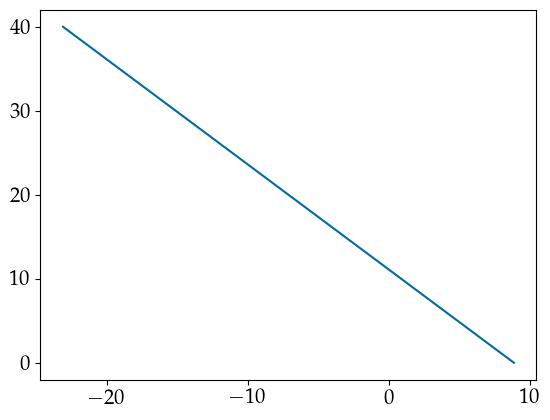

In [268]:
pt = 40
# plt.plot(b_endo[pt,:], leverage[pt,:])
# plt.plot(ss['qh']*ss.internals[hh_name]['h_bhat_grid'])
plt.plot(b_endo[pt,:], ss['qh']*ss.internals[hh_name]['h_bhat_grid'])
print(ss['qh']*ss.internals[hh_name]['h_bhat_grid'])
print(b_endo[pt,:])

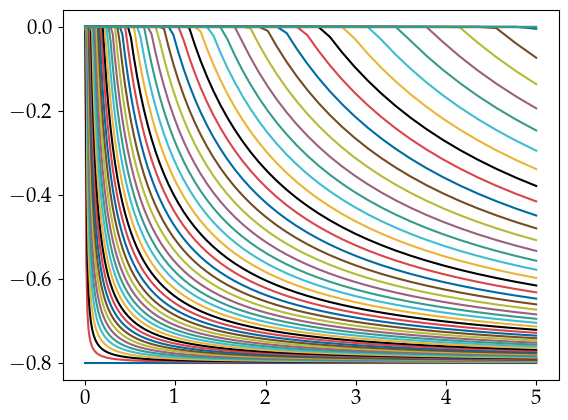

In [246]:
# print(b_endo.shape, XX.shape, ss.internals['hh_housecons']['D'][0,:,:].shape)

leverage = b_endo/(ss['qh']*ss.internals[hh_name]['h_bhat_grid'])

leverage[leverage > 0] = 0
for hi in range(60):
    plt.plot(ss.internals[hh_name]['h_bhat_grid'], leverage[hi,:])
    # plt.plot(ss.internals[hh_name]['h_bhat_grid'], b_endo[hi,:])

# for hi in range(0,70):
#     plt.plot(leverage[:,hi], ss.internals['hh_housecons']['D'][0,:,hi], label = f'h = {ss.internals[hh_name]["h_bhat_grid"][hi]:0.2f}')
#     # plt.plot(ss.internals[hh_name]['b_bhat_grid'], leverage[:,hi])
# plt.xlim(-0.82, 1)
# # plt.ylim(None, 0.01)

# z = 1
# for hi in range(0,4):
#     plt.plot(leverage[hi,:], ss.internals['hh_housecons']['D'][z,hi,:])
# plt.xlim(-0.82, -0.78)

In [243]:
np.sum(ss.internals['hh_housecons']['D'][z,0,:])
print(leverage[40,:])

[ 1.10646531e+03  8.89414330e+01  4.49794574e+01  2.94791214e+01
  2.15656688e+01  1.67677532e+01  1.35507048e+01  1.12456322e+01
  9.51435331e+00  8.16749417e+00  7.09075093e+00  6.21104512e+00
  5.47947478e+00  4.86207998e+00  4.33454060e+00  3.87898233e+00
  3.48197367e+00  3.13322614e+00  2.82472560e+00  2.55013658e+00
  2.30438451e+00  2.08335681e+00  1.88368516e+00  1.70258436e+00
  1.53773128e+00  1.38717285e+00  1.24925510e+00  1.12256800e+00
  1.00590202e+00  8.98213728e-01  7.98598150e-01  7.06266544e-01
  6.20528294e-01  5.40776091e-01  4.66473727e-01  3.97145974e-01
  3.32370143e-01  2.71769012e-01  2.15004869e-01  1.61774463e-01
  1.11804718e-01  6.48490684e-02  2.06843161e-02 -2.08920709e-02
 -6.00642960e-02 -9.70002590e-02 -1.31853318e-01 -1.64763827e-01
 -1.95860482e-01 -2.25261502e-01 -2.53075667e-01 -2.79403242e-01
 -3.04336782e-01 -3.27961858e-01 -3.50357697e-01 -3.71597752e-01
 -3.91750212e-01 -4.10878462e-01 -4.29041491e-01 -4.46294258e-01
 -4.62688027e-01 -4.78270

In [187]:
100*ss.internals['hh_housecons']['D'][1,:,40]

array([4.45789373e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.06518795e-01, 5.09765061e-01,
       6.33515882e-01, 1.69245932e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.89088323e-04, 9.98433716e-04, 2.48652738e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

## Sign Effects of Monetary Policy

In [35]:
sig_r = 0.0075
dr = np.zeros(T)
dr[0] = sig_r
dr_neg = -dr
rstar_shock = {"epsm": dr}

ifr_pos = hank.solve_impulse_nonlinear(ss, unknowns, targets, {"epsm": dr}, internals=[hh_name], verbose = False, 
                                       options={'taylor': {'verbose': False}})
ifr_neg = hank.solve_impulse_nonlinear(ss, unknowns, targets, {"epsm": -dr}, internals=[hh_name], verbose = False,
                                       options={'taylor': {'verbose': False}})

# ifr_main_lowgam = hank.solve_impulse_nonlinear(ss_lowgamm, unknowns, targets, rstar_shock, internals=[hh_name], verbose = False)
# ifr_main_lin = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock, internals=[hh_name], verbose = False)

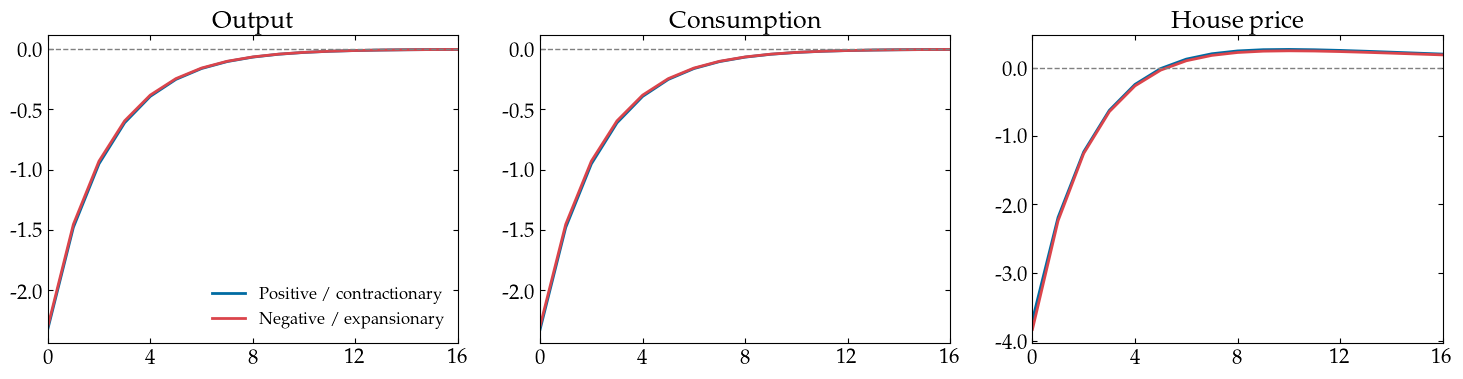

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,12*1/3))
ax = ax.flatten()

var_name = {'Y': 'Output', 'C_BHAT': 'Consumption', 'qh': 'House price'}

for i, (key, value) in enumerate(var_name.items()):   
    # ax[i].plot(100*ifr_main[key][:21])
    if key in devss:   
        ax[i].plot(100*(ifr_pos[key][:H]/ss[key]), linewidth=2, label = 'Model')
        ax[i].plot(100*(ifr_neg[key][:H]/ss[key]), linewidth=2, color = '#DB444B', label = 'Model')
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
    else:
        ax[i].plot(100*((1 + ss[key] +ifr_pos[key][:H])**4-1), linewidth=2, label = 'Model')
        ax[i].plot(100*((1 + ss[key] +ifr_neg[key][:H])**4-1), linewidth=2, color = '#DB444B', label = 'Model')
        ax[i].axhline(y=100*((1 + ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1) 
    
    ax[i].set_title(var_name[key])
    if i == 0:
        ax[i].legend(['Positive / contractionary', 'Negative / expansionary'], fontsize=12, frameon=False)

plt.show()

## Different housing wealth effects

In [85]:
input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p']
output_list = ['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI', 'UCE_BHAT']

sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r

# Baseline Jacobian 
Js = {hh_name: hh1.jacobian(ss, inputs=input_list, outputs=output_list, T=T)}
Js_lowr = {hh_name: hh1.jacobian(ss_lowr, inputs=input_list, outputs=output_list, T=T)}
print(hh1.name) # verify that 'hh_housecons_sep' is the name of the het-agent household block
xi = 0.97
jac_ = {}
for output in output_list:
    jac_[output] = {}
    for input in input_list:
        jac_[output][input] = manipulate_separable(Js[hh_name][output][input], E_sticky_exp(xi))

jac_lowr = {}
for output in output_list:
    jac_lowr[output] = {}
    for input in input_list:
        jac_lowr[output][input] = manipulate_separable(Js_lowr[hh_name][output][input], E_sticky_exp(xi))

# Jacobian with Sticky Expectations
# Js_myopic = {hh_name: JacobianDict(jac_, inputs=input_list, outputs=output_list, name='hh1')}

combine_blocks = combine(blocks) 
Js_myopic = {hh_name: JacobianDict(jac_, inputs=input_list, 
                                   outputs=output_list, name='hank')}
Js_myopic_lowr = {hh_name: JacobianDict(jac_lowr, inputs=input_list, 
                                   outputs=output_list, name='hank')}

irf_myopic = (combine_blocks.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                              Js=Js_myopic, inputs=['epsm'], 
                                              outputs=['Y', 'C_BHAT', 'pi', 'r', 'i',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w']) @ {"epsm": dr})
print("irf_B_myopic completed")

irf_myopic_lowr = (combine_blocks.solve_jacobian(ss_lowr, unknowns=unknowns, targets=targets, T=T,
                                                Js=Js_myopic_lowr, inputs=['epsm'], outputs=['Y', 'C_BHAT', 'pi', 'r', 'i',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w']) @ {"epsm": dr})

hh_housecons_sep
irf_B_myopic completed


In [87]:
irf_myopic_lowr['Div']

array([ 6.90897621e-03,  1.19637372e-02,  1.40720751e-02,  1.41689224e-02,
        1.30379355e-02,  1.12828128e-02,  9.32505770e-03,  7.42934138e-03,
        5.73963400e-03,  4.31609004e-03,  3.16648638e-03,  2.26932388e-03,
        1.58930529e-03,  1.08712004e-03,  7.25185971e-04,  4.70530415e-04,
        2.95792806e-04,  1.79162696e-04,  1.03803583e-04,  5.70730473e-05,
        2.97088938e-05,  1.50755786e-05,  8.51875747e-06,  6.84311941e-06,
        7.90682217e-06,  1.03149879e-05,  1.31925134e-05,  1.60185440e-05,
        1.85080216e-05,  2.05284723e-05,  2.20425781e-05,  2.30692214e-05,
        2.36575787e-05,  2.38703490e-05,  2.37733189e-05,  2.34292549e-05,
        2.28946729e-05,  2.22184572e-05,  2.14416129e-05,  2.05976733e-05,
        1.97134484e-05,  1.88099168e-05,  1.79031406e-05,  1.70051320e-05,
        1.61246334e-05,  1.52677953e-05,  1.44387498e-05,  1.36400824e-05,
        1.28732153e-05,  1.21387117e-05,  1.14365133e-05,  1.07661248e-05,
        1.01267533e-05,  

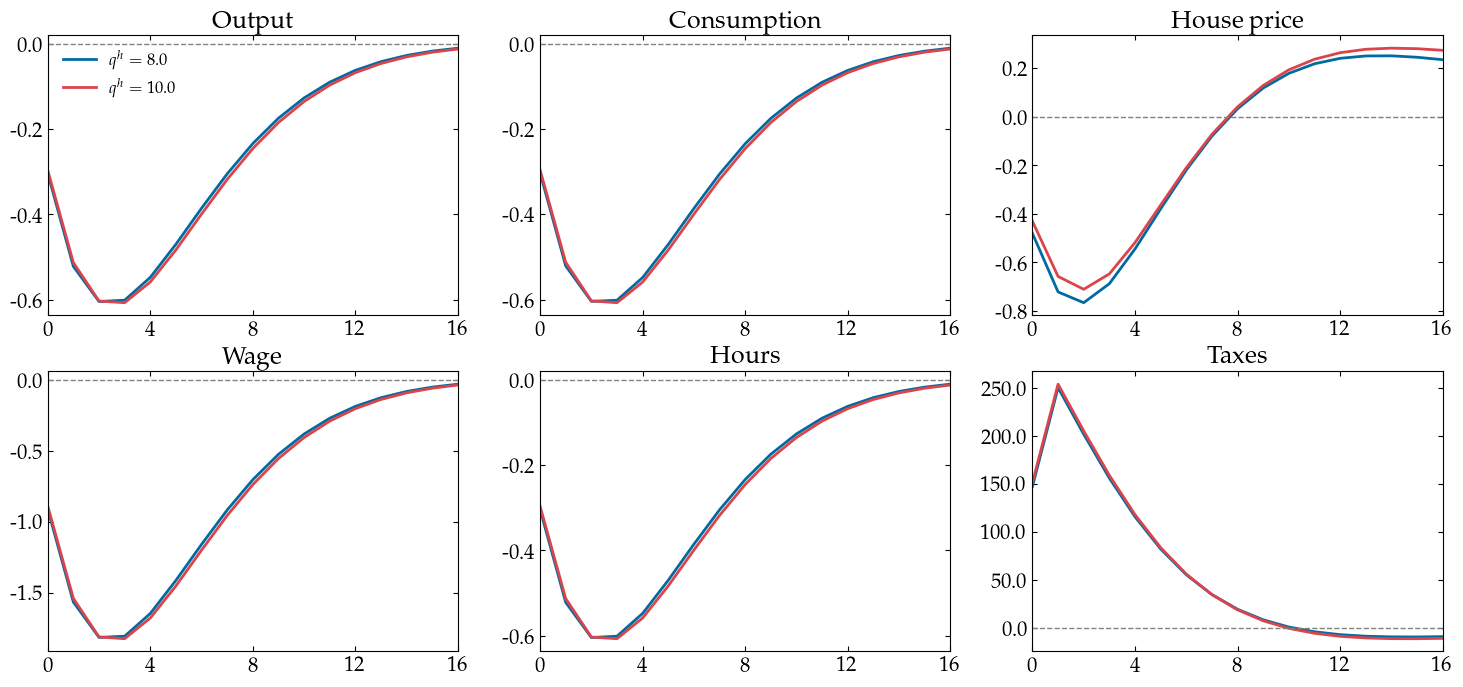

In [90]:
fig, ax = plt.subplots(2, 3, figsize=(18,12*2/3))
ax = ax.flatten()

var_name = {'Y': 'Output', 'C_BHAT': 'Consumption', 'qh': 'House price',
            'w': 'Wage', 'N': 'Hours', 'Tax': 'Taxes'}

for i, (key, value) in enumerate(var_name.items()):   
    # ax[i].plot(100*ifr_main[key][:21])
    if key in devss:   
        ax[i].plot(100*(irf_myopic[key][:H]/ss[key]), linewidth=2, label = 'Model')
        ax[i].plot(100*(irf_myopic_lowr[key][:H]/ss_lowr[key]), linewidth=2, color = '#DB444B', label = 'Model')
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
    # else:
    #     ax[i].plot(100*((1 + ss[key] +ifr_pos[key][:H])**4-1), linewidth=2, label = 'Model')
    #     ax[i].plot(100*((1 + ss[key] +ifr_neg[key][:H])**4-1), linewidth=2, color = '#DB444B', label = 'Model')
    #     ax[i].axhline(y=100*((1 + ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1) 
    
    ax[i].set_title(var_name[key])
    if i == 0:
        ax[i].legend([fr"$q^h = 8.0$", fr"$q^h = 10.0$"], fontsize=12, frameon=False)

plt.show()

In [75]:
# empty namespace to store decompositions
decomp = SimpleNamespace()
decomp.myopic = SimpleNamespace()
decomp.attention = SimpleNamespace()

# empty namespace to store irfs
irf = SimpleNamespace()
irf.lowleverage = SimpleNamespace()
irf.highleverage = SimpleNamespace()

input_list_decomp = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w']
for k in input_list_decomp:
    setattr(decomp.myopic, f'dC_d{k}', Js_myopic[hh_name]['C_BHAT'][k] @ irf_myopic[k])
    setattr(decomp.attention, f'dC_d{k}', Js_myopic_lowr[hh_name]['C_BHAT'][k] @ irf_myopic_lowr[k])

decomp_dict_ll = vars(decomp.myopic)
decomp_dict_hl = vars(decomp.attention)

total_response_ll = 0
total_response_hl = 0

for (key, value) in decomp_dict_ll.items():
    total_response_ll += value

for (key, value) in decomp_dict_hl.items():
    total_response_hl += value

housing_effect_ll = decomp.myopic.dC_dqh + decomp.myopic.dC_dqh_lag
housing_effect_hl = decomp.attention.dC_dqh + decomp.attention.dC_dqh_lag
indirect_effect_ll = decomp.myopic.dC_dN + decomp.myopic.dC_dTax + decomp.myopic.dC_dDiv + decomp.myopic.dC_dw
indirect_effect_hl = decomp.attention.dC_dN + decomp.attention.dC_dTax + decomp.attention.dC_dDiv + decomp.attention.dC_dw
direct_effect_ll = decomp.myopic.dC_dr
direct_effect_hl = decomp.attention.dC_dr

assert np.allclose(total_response_ll/ss['C_BHAT'], irf_B_myopic['C_BHAT']/ss['C_BHAT'])

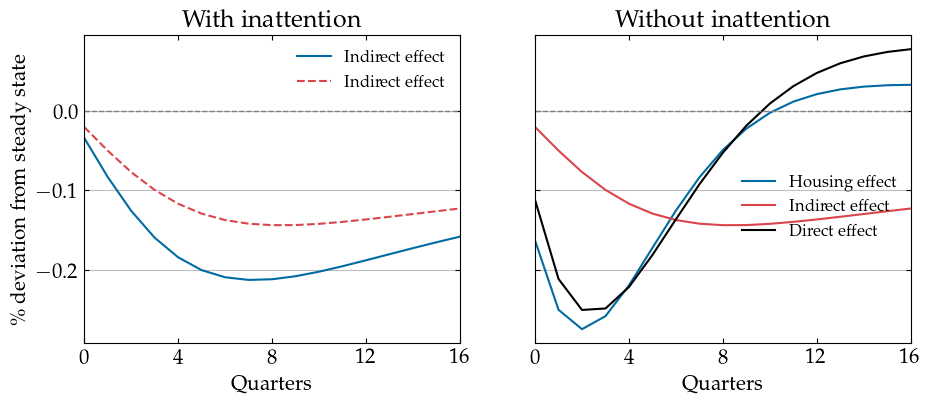

In [80]:
decomp_dict_ll = vars(decomp.myopic)
decomp_dict_hl = vars(decomp.attention)

total_response_ll = 0
total_response_hl = 0

for (key, value) in decomp_dict_ll.items():
    total_response_ll += value

for (key, value) in decomp_dict_hl.items():
    total_response_hl += value

housing_effect_ll = decomp.myopic.dC_dqh + decomp.myopic.dC_dqh_lag
housing_effect_hl = decomp.attention.dC_dqh + decomp.attention.dC_dqh_lag
indirect_effect_ll = decomp.myopic.dC_dN + decomp.myopic.dC_dTax + decomp.myopic.dC_dDiv + decomp.myopic.dC_dw
indirect_effect_hl = decomp.attention.dC_dN + decomp.attention.dC_dTax + decomp.attention.dC_dDiv + decomp.attention.dC_dw
direct_effect_ll = decomp.myopic.dC_dr
direct_effect_hl = decomp.attention.dC_dr

fig, ax = plt.subplots(1, 2, figsize=(16*2/3,4), sharey=True)
ax = ax.flatten()
H = 17
interval = 2

ii = 0
# ax[ii].plot(100*housing_effect_ll[:H], label='Housing effect, qh = 8')
# ax[ii].plot(100*housing_effect_hl[:H], label='Housing effect, qh = 16', ls = '--')
ax[ii].plot(100*indirect_effect_ll[:H], label='Indirect effect')
ax[ii].plot(100*indirect_effect_hl[:H], label='Indirect effect', ls = '--')
# ax[ii].plot(100*direct_effect_ll[:H], label='Direct effect')
# ax[ii].plot(100*direct_effect_hl[:H], label='Direct effect', ls = '--')
ax[ii].set_title('With inattention')
ax[ii].set_xlabel('Quarters')
ax[ii].set_ylabel('\% deviation from steady state')
# ax[ii].set_xticks(range(0, H + 1, interval))
# ax[ii].set_xticklabels(range(0, H + 1, interval))
ax[ii].xaxis.set_major_locator(MultipleLocator(4))
ax[ii].set_xlim(0, 16)
ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax[ii].grid(True, axis='y', color='black', alpha=0.25, linestyle='-')
ax[ii].legend(fontsize=12, frameon=False)

ii += 1
ax[ii].plot(100*housing_effect_hl[:H], label='Housing effect')
ax[ii].plot(100*indirect_effect_hl[:H], label='Indirect effect')
ax[ii].plot(100*direct_effect_hl[:H], label='Direct effect')
ax[ii].set_title('Without inattention')
ax[ii].set_xlabel('Quarters')
ax[ii].set_xlim(0, 16)
ax[ii].xaxis.set_major_locator(MultipleLocator(4))
ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax[ii].legend(fontsize=12, frameon=False, loc='center right', bbox_to_anchor=(1, 0.44))
ax[ii].grid(True, axis='y', color='black', alpha=0.25, linestyle='-')

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"

    # Save the plot
    fig.savefig(os.path.join(figure_path, 'Consumption Decomposition.pdf'), dpi=1000, bbox_inches='tight')

In [315]:
sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r

ifr_lw = hank.solve_impulse_nonlinear(ss, unknowns, targets, {"epsm": dr}, internals=[hh_name], verbose = False, 
                                       options={'taylor': {'verbose': False}})
ifr_hw = hank.solve_impulse_nonlinear(ss_highwealth, unknowns, targets, {"epsm": dr}, internals=[hh_name], verbose = False,
                                       options={'taylor': {'verbose': False}})

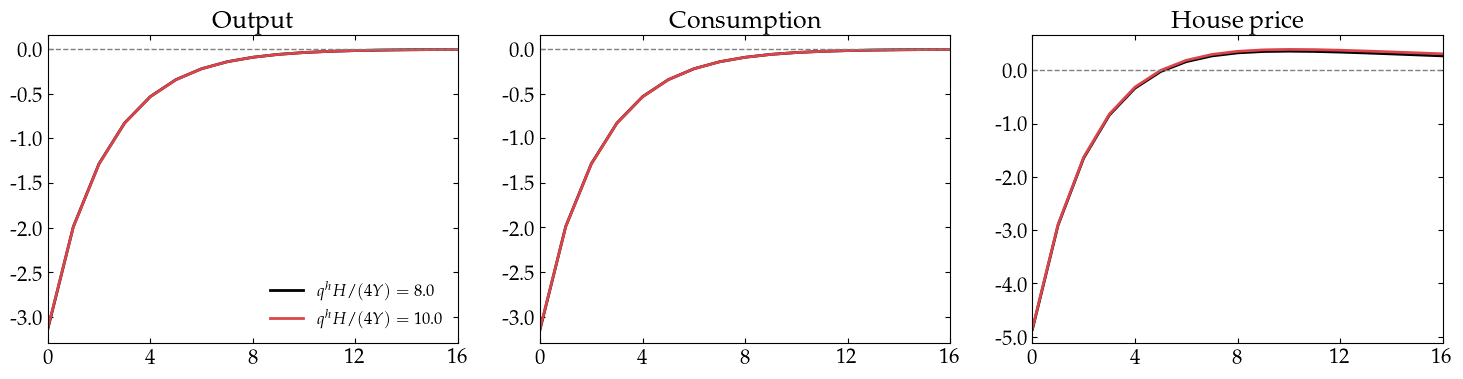

In [316]:
fig, ax = plt.subplots(1, 3, figsize=(18,12*1/3))
ax = ax.flatten()

var_name = {'Y': 'Output', 'C_BHAT': 'Consumption', 'qh': 'House price'}

for i, (key, value) in enumerate(var_name.items()):   
    # ax[i].plot(100*ifr_main[key][:21])
    if key in devss:   
        ax[i].plot(100*(ifr_lw[key][:H]/ss[key]), linewidth=2, label = 'Model')
        ax[i].plot(100*(ifr_hw[key][:H]/ss_highwealth[key]), linewidth=2, color = '#DB444B', label = 'Model')
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
    # else:
    #     ax[i].plot(100*((1 + ss[key] +ifr_pos[key][:H])**4-1), linewidth=2, label = 'Model')
    #     ax[i].plot(100*((1 + ss[key] +ifr_neg[key][:H])**4-1), linewidth=2, color = '#DB444B', label = 'Model')
    #     ax[i].axhline(y=100*((1 + ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1) 
    
    ax[i].set_title(var_name[key])
    if i == 0:
        ax[i].legend([fr"$q^hH/(4Y) = 8.0$", fr"$q^hH/(4Y) = 10.0$"], fontsize=12, frameon=False)

plt.show()

## Sticky expectations

In [131]:
@njit
def manipulate_separable(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

def E_sticky_exp(theta, T=T, sticky_info=False):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    if sticky_info:
        return E
    else:
        E = np.triu(E, +1) + np.tril(np.ones((T, T)))
        return E

In [132]:
input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p']
output_list = ['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI', 'UCE_BHAT']

sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r

# Baseline Jacobian 
Js = {hh_name: hh1.jacobian(ss, inputs=input_list, outputs=output_list, T=T)}
print(hh1.name) # verify that 'hh_housecons_sep' is the name of the het-agent household block
xi = 0.97
jac_ = {}
for output in output_list:
    jac_[output] = {}
    for input in input_list:
        jac_[output][input] = manipulate_separable(Js[hh_name][output][input], E_sticky_exp(xi))

# Jacobian with Sticky Expectations
Js_myopic = {hh_name: JacobianDict(jac_, inputs=input_list, outputs=output_list, name='hh1')}

combine_blocks = combine(blocks) 
Js_myopic = {hh_name: JacobianDict(jac_, inputs=input_list, 
                                   outputs=output_list, name='hank')}

irf_B_myopic = (combine_blocks.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                              Js=Js_myopic, inputs=['epsm'], 
                                              outputs=['Y', 'C_BHAT', 'pi', 'r', 'i',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w']) @ {"epsm": dr})
print("irf_B_myopic completed")

irf_B = (combine_blocks.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                        Js=Js, inputs=['epsm'], outputs=['Y', 'C_BHAT', 'pi', 'r', 'i',
                                                       'qh', 'qh_lag', 'Tax', 'Div', 'N', 'w']) @ {"epsm": dr})

hh_housecons_sep
irf_B_myopic completed


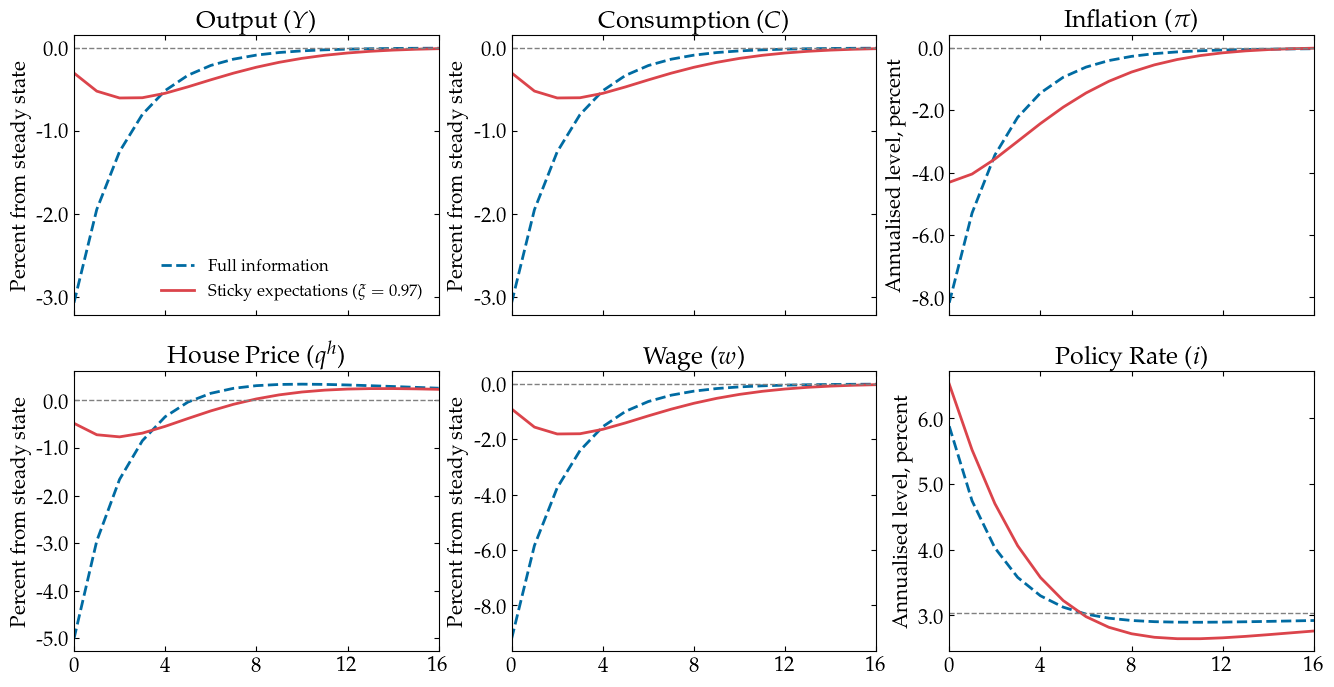

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(16,12*2/3), sharex = True)
ax = ax.flatten()

H = 17
var_name = {'Y': r'Output ($Y$)', 'C_BHAT': r'Consumption ($C$)', 
            'pi': r'Inflation ($\pi$)', 'qh': r'House Price ($q^h$)',
            'w': r'Wage ($w$)', 'i': r'Policy Rate ($i$)'}

for i, (key, value) in enumerate(var_name.items()):   
    # ax[i].plot(100*ifr_main[key][:21])
    if key in devss:   
        ax[i].plot(100*(irf_B[key][:H]/ss[key]), linewidth=2, linestyle='--')
        ax[i].plot(100*(irf_B_myopic[key][:H]/ss[key]), linewidth=2)
        ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Percent from steady state')
    else:
        ax[i].plot(100*((1 + ss[key] +irf_B[key][:H])**4-1), linewidth=2, linestyle='--')
        ax[i].plot(100*((1 + ss[key] +irf_B_myopic[key][:H])**4-1), linewidth=2)
        ax[i].axhline(y=100*((1 + ss[key])**4 - 1), color='grey', linestyle='--', linewidth=1.0)
        ax[i].set_ylabel('Annualised level, percent')

    if i == 0:
        ax[i].legend(['Full information',fr'Sticky expectations ($\xi =$ {xi})'], fontsize=12, frameon=False)
    ax[i].set_title(var_name[key])

    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_xlim(0, H -1)
    
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"

    # Save the plot
    fig.savefig(os.path.join(figure_path, 'MainModelIrf_v2.pdf'), dpi=1000, bbox_inches='tight')

### Decomposing the effects of a monetary policy shock

In [134]:
# empty namespace to store decompositions
decomp = SimpleNamespace()
decomp.myopic = SimpleNamespace()
decomp.attention = SimpleNamespace()

# empty namespace to store irfs
irf = SimpleNamespace()
irf.lowleverage = SimpleNamespace()
irf.highleverage = SimpleNamespace()

input_list_decomp = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w']
for k in input_list_decomp:
    setattr(decomp.myopic, f'dC_d{k}', Js_myopic[hh_name]['C_BHAT'][k] @ irf_B_myopic[k])
    setattr(decomp.attention, f'dC_d{k}', Js[hh_name]['C_BHAT'][k] @ irf_B[k])

decomp_dict_ll = vars(decomp.myopic)
decomp_dict_hl = vars(decomp.attention)

total_response_ll = 0
total_response_hl = 0

for (key, value) in decomp_dict_ll.items():
    total_response_ll += value

for (key, value) in decomp_dict_hl.items():
    total_response_hl += value

housing_effect_ll = decomp.myopic.dC_dqh + decomp.myopic.dC_dqh_lag
housing_effect_hl = decomp.attention.dC_dqh + decomp.attention.dC_dqh_lag
indirect_effect_ll = decomp.myopic.dC_dN + decomp.myopic.dC_dTax + decomp.myopic.dC_dDiv + decomp.myopic.dC_dw
indirect_effect_hl = decomp.attention.dC_dN + decomp.attention.dC_dTax + decomp.attention.dC_dDiv + decomp.attention.dC_dw
direct_effect_ll = decomp.myopic.dC_dr
direct_effect_hl = decomp.attention.dC_dr

assert np.allclose(total_response_ll/ss['C_BHAT'], irf_B_myopic['C_BHAT']/ss['C_BHAT'])

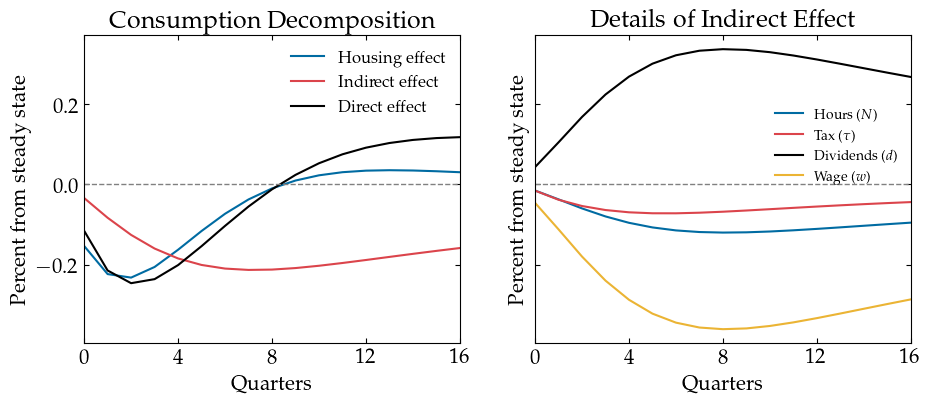

In [139]:
fig, ax = plt.subplots(1, 2, figsize=(16*2/3,4), sharey=True)
ax = ax.flatten()
H = 17
interval = 2
plot_total = False

ii = 0
ax[ii].plot(100*housing_effect_ll[:H]/ss['C_BHAT'], label='Housing effect')
ax[ii].plot(100*indirect_effect_ll[:H]/ss['C_BHAT'], label='Indirect effect')
ax[ii].plot(100*direct_effect_ll[:H]/ss['C_BHAT'], label='Direct effect')

if plot_total:
    ax[ii].plot(100*total_response_ll[:H], label='Total (for check)')
    ax[ii].plot(100*(irf_B_myopic['C_BHAT'][:H]), ls = '--', linewidth=2)

ax[ii].set_title('Consumption Decomposition')
ax[ii].set_xlabel('Quarters')
ax[ii].set_ylabel('Percent from steady state')
ax[ii].xaxis.set_major_locator(MultipleLocator(4))
ax[ii].set_xlim(0, 16)
ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax[ii].legend(fontsize=12, frameon=False) #, loc='center right', bbox_to_anchor=(1, 0.44)

ii += 1
ax[ii].plot(100*decomp.myopic.dC_dN[:H]/ss['C_BHAT'], label=r'Hours ($N$)')
ax[ii].plot(100*decomp.myopic.dC_dTax[:H]/ss['C_BHAT'], label=r'Tax ($\tau$)')
ax[ii].plot(100*decomp.myopic.dC_dDiv[:H]/ss['C_BHAT'], label=r'Dividends ($d$)')
ax[ii].plot(100*decomp.myopic.dC_dw[:H]/ss['C_BHAT'], label=r'Wage ($w$)')
ax[ii].set_title('Details of Indirect Effect')
ax[ii].set_xlabel('Quarters')
ax[ii].set_ylabel('Percent from steady state')
ax[ii].xaxis.set_major_locator(MultipleLocator(4))
ax[ii].set_xlim(0, 16)
ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax[ii].legend(fontsize=10, frameon=False, ncols=1, loc='center right', bbox_to_anchor=(1, 0.64))

plt.show()

In [33]:
housing_2y = np.sum(100*housing_effect_ll[:8])
direct_2y = np.sum(100*direct_effect_ll[:8])
indirect_2y = np.sum(100*indirect_effect_ll[:8])
c_2y = np.sum(100*total_response_ll[:8])

print(f'2y housing effect: {housing_2y:0.2f} %')
print(f'2y consumption effect: {c_2y:0.2f} %' )
print(f'Housing effect 2y share: {100*housing_2y/c_2y:0.2f} %')

assert np.allclose(housing_2y + direct_2y + indirect_2y, c_2y)
print(c_2y - (housing_2y + direct_2y + indirect_2y))

2y housing effect: -1.20 %
2y consumption effect: -3.74 %
Housing effect 2y share: 32.20 %
-4.440892098500626e-16


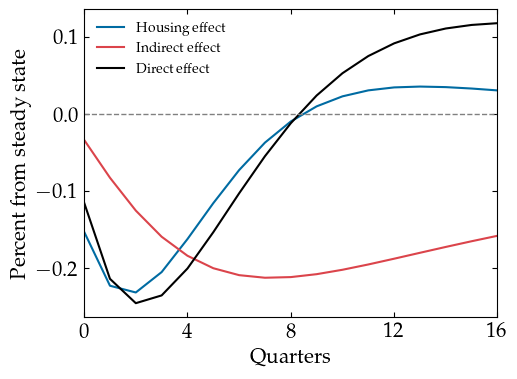

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16*1/3,4), sharey=True)
# ax = ax.flatten()
H = 17
interval = 2
plot_total = False

ii = 0
ax.plot(100*housing_effect_ll[:H]/ss['C_BHAT'], label='Housing effect')
ax.plot(100*indirect_effect_ll[:H]/ss['C_BHAT'], label='Indirect effect')
ax.plot(100*direct_effect_ll[:H]/ss['C_BHAT'], label='Direct effect')

if plot_total:
    ax.plot(100*total_response_ll[:H], label='Total (for check)')
    ax.plot(100*(irf_B_myopic['C_BHAT'][:H]), ls = '--', linewidth=2)

# ax.set_title('Consumption Decomposition')
ax.set_xlabel('Quarters')
ax.set_ylabel('Percent from steady state')
ax.xaxis.set_major_locator(MultipleLocator(4))
ax.set_xlim(0, 16)
ax.axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax.legend(fontsize=10, frameon=False) #, loc='center right', bbox_to_anchor=(1, 0.44)

# ii += 1
# ax.plot(100*decomp.myopic.dC_dN[:H]/ss['C_BHAT'], label=r'Hours ($N$)')
# ax.plot(100*decomp.myopic.dC_dTax[:H]/ss['C_BHAT'], label=r'Tax ($\tau$)')
# ax.plot(100*decomp.myopic.dC_dDiv[:H]/ss['C_BHAT'], label=r'Dividends ($d$)')
# ax.plot(100*decomp.myopic.dC_dw[:H]/ss['C_BHAT'], label=r'Wage ($w$)')
# # ax.set_title('Details of Indirect Effect')
# ax.set_xlabel('Quarters')
# ax.set_ylabel('Percent from steady state')
# ax.xaxis.set_major_locator(MultipleLocator(4))
# ax.set_xlim(0, 16)
# ax.axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
# ax.tick_params(direction='in', top=True, bottom=True, left=True, right=True)
# ax.legend(fontsize=10, frameon=False, ncols=1, loc='center right', bbox_to_anchor=(1, 0.7))

plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"

    # Save the plot
    fig.savefig(os.path.join(figure_path, 'ConsumptionDecomp_v2.pdf'), dpi=1000, bbox_inches='tight')

# 5. Empirical IRFs plot

In [120]:
import pandas as pd
import os

# Define the path to the Excel file
subfolder = 'Misc'
filename = 'rrshockirfs_v5.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)

# Load the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name='gamma', header = None)

col_name = ['r', 'C_BHAT', 'qh', 'Y', 'pi', 'Investment', 'w', 'Mortgage', 'Rent']
df.columns = col_name

# col_name = ['r', 'C_BHAT', 'qh', 'Y', 'pi', 'N', 'Investment', 'w', 'Mortgage']
bounds_name = ['lb', 'ub']
col_name_bands = []
for i in bounds_name:
    for j in col_name:
        col_name_bands.append(f'{i}_{j}')
df_bands = pd.read_excel(file_path, sheet_name='gammabands', header = None)
df_bands.columns = col_name_bands

filename = 'rrshockirfs_v5_68bands.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)
df_bands68 = pd.read_excel(file_path, sheet_name='gammabands', header = None)
df_bands68.columns = col_name_bands

filename = 'JKShockFedPoorManirfs_v1.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)
df_JkPoorMan = pd.read_excel(file_path, sheet_name='gamma', header = None)
df_JkPoorMan.columns = col_name

filename = 'JKShockFedMedianirfs_v1.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)
df_JkMedian = pd.read_excel(file_path, sheet_name='gamma', header = None)
df_JkMedian.columns = col_name

filename = 'marshockirfs_v1.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)
df_Mar = pd.read_excel(file_path, sheet_name='gamma', header = None)
df_Mar.columns = col_name

# col_name = ['r', 'C_BHAT', 'qh', 'Y', 'pi', 'SPX', 'unemp']
# col_name = ['r', 'C_BHAT', 'qh', 'Y', 'pi', 'N', 'Investment', 'w', 'Mortgage']

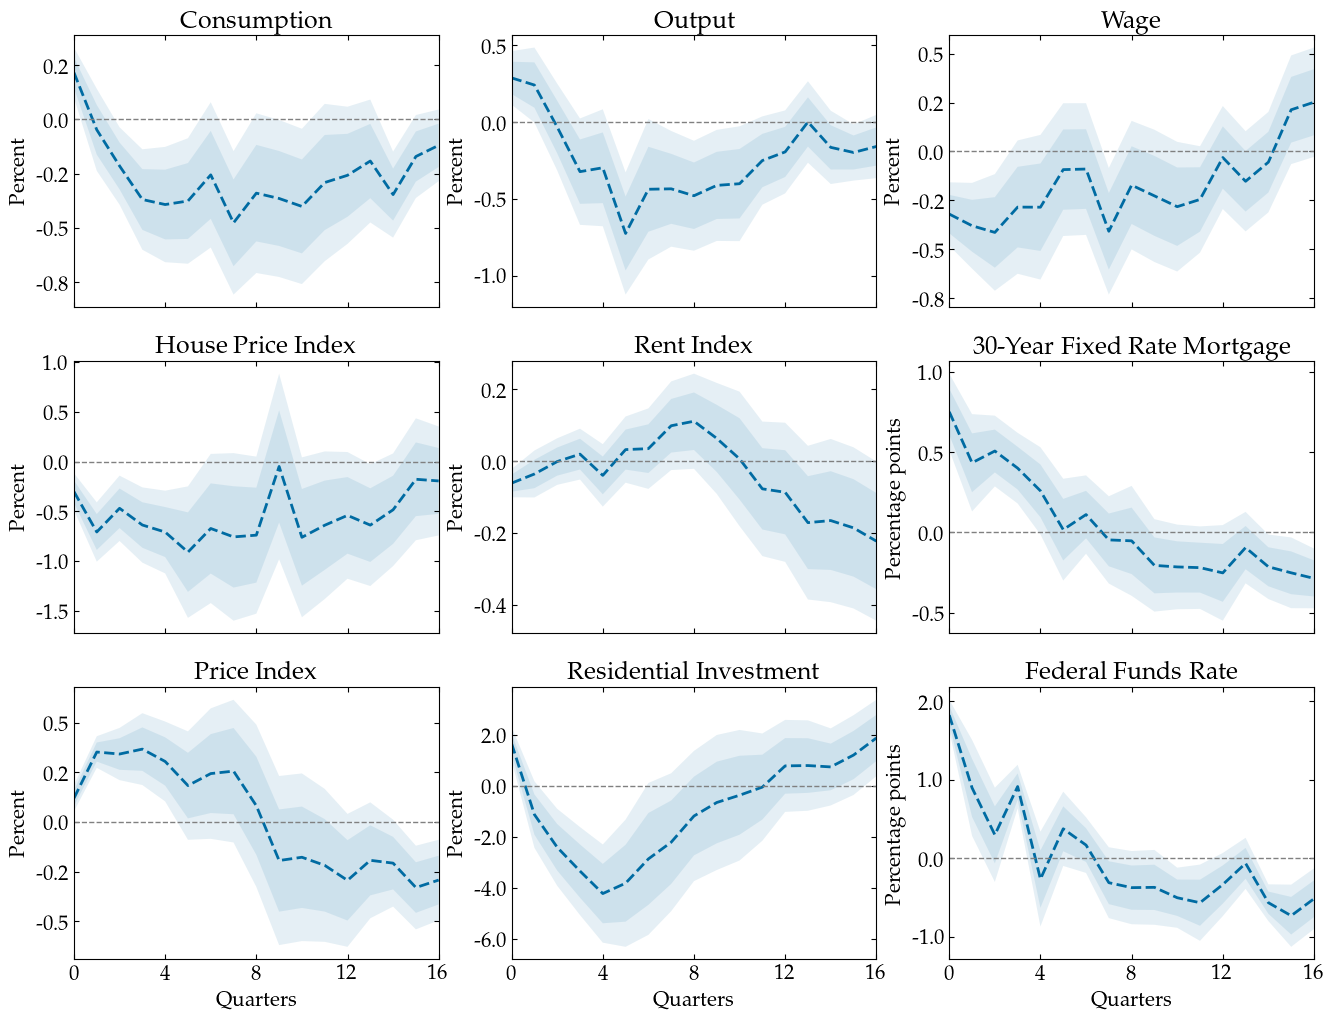

In [126]:
fig, ax = plt.subplots(3, 3, figsize=(16,12), sharex=True)
ax = ax.flatten()

var_name = {'C_BHAT': 'Consumption', 'Y': 'Output', 'w': 'Wage',
            'qh': 'House Price Index', 'Rent': 'Rent Index','Mortgage': '30-Year Fixed Rate Mortgage',
            'pi': 'Price Index', 'Investment': 'Residential Investment', 'r': 'Federal Funds Rate'}

H = 17
interval = 2

# Function to format y-axis labels with the same number of digits
def format_func(value, tick_number):
    return f'{value:.1f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*df[key][:H], ls = '--', linewidth=2, label = 'Romer \& Romer')
    ax[i].fill_between(range(H), 100*df_bands[f"lb_{key}"][:H], 100*df_bands[f"ub_{key}"][:H], alpha = 0.1, edgecolor = None)
    ax[i].fill_between(range(H), 100*df_bands68[f"lb_{key}"][:H], 100*df_bands68[f"ub_{key}"][:H], 
                       alpha = 0.1, color = '#006BA2', edgecolor = None)
    
    plot_highfreq = False
    if plot_highfreq:
        ax[i].plot(100*df_JkPoorMan[key][:H], ls = 'dotted', linewidth=2, label = 'Jarocinski \& Karadi, Poor man')
        ax[i].plot(100*df_JkMedian[key][:H], linewidth=2, ls = 'dashdot', label = 'Jarocinski \& Karadi, Median')
        ax[i].plot(100*df_Mar[key][:H], linewidth=2, label = 'Miranda-Agrippino \& Ricco')
        if i == 6:
            ax[i].legend(fontsize=10, frameon=False)

    ax[i].set_title(var_name[key])
    ax[i].set_xticks(range(0, H + 1, interval))
    ax[i].set_xticklabels(range(0, H + 1, interval))
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].set_xlim(0, 16)
    ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    if key == 'r' or key == 'Mortgage':
        ax[i].set_ylabel('Percentage points')
    else :
        ax[i].set_ylabel('Percent')

    if i == 6 or i == 7 or i == 8:
        ax[i].set_xlabel('Quarters')
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"

    # Save the plot
    fig.savefig(os.path.join(figure_path, 'Main Empirical IRF_v3.pdf'), dpi=1000, bbox_inches='tight')

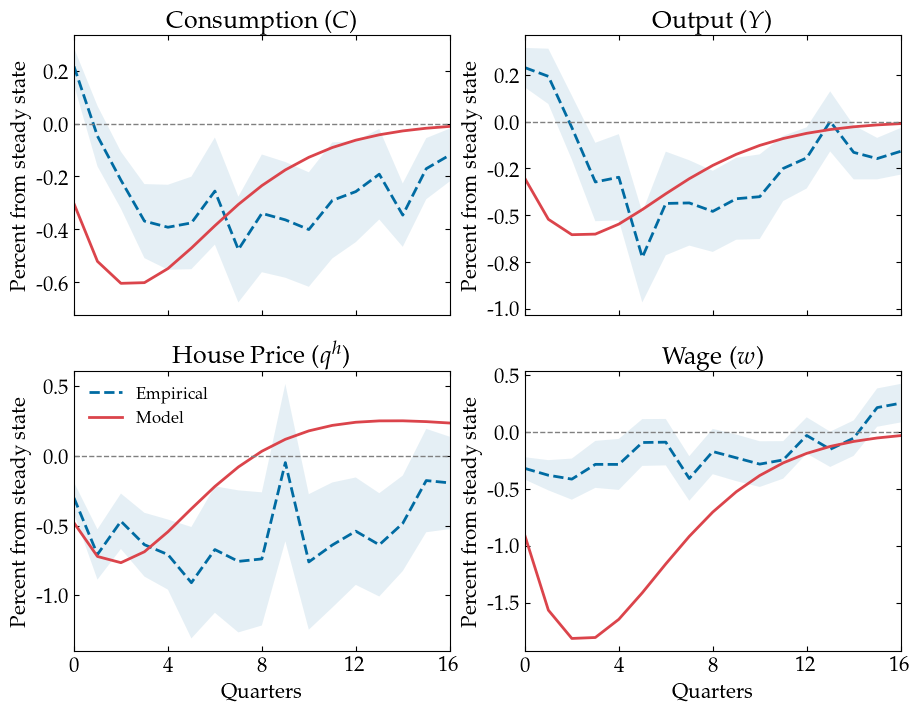

In [150]:
fig, ax = plt.subplots(2, 2, figsize=(16*2/3,8), sharex=True)
ax = ax.flatten()

var_name = {'C_BHAT': r'Consumption ($C$)', 'Y': 'Output ($Y$)', 'qh': 'House Price ($q^h$)', 'w': 'Wage ($w$)'}

H = 17
interval = 2

# Function to format y-axis labels with the same number of digits
def format_func(value, tick_number):
    return f'{value:.1f}'  # Format with 2 decimal places

formatter = FuncFormatter(format_func)

for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*df[key][:H], ls = '--', linewidth=2, color = '#006BA2', label = 'Empirical')
    ax[i].fill_between(range(H), 100*df_bands68[f"lb_{key}"][:H], 100*df_bands68[f"ub_{key}"][:H], 
                       alpha = 0.1, color = '#006BA2', edgecolor = None)
    # ax[i].plot(100*irf_B_myopic[key][:H], linewidth=2, color = '#DB444B', label = 'Model')

    if key in devss:   
        ax[i].plot(100*(irf_B_myopic[key][:H]/ss[key]), linewidth=2, color = '#DB444B', label = 'Model')
        # ax[i].plot(100*(irf_B[key][:H]/ss[key]), ls = '--', linewidth=2)

    ax[i].set_title(var_name[key])
    ax[i].set_xticks(range(0, H + 1, interval))
    ax[i].set_xticklabels(range(0, H + 1, interval))
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    ax[i].set_xlim(0, 16)
    ax[i].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
    ax[i].yaxis.set_major_formatter(formatter)
    ax[i].xaxis.set_major_locator(MultipleLocator(4))
    ax[i].set_ylabel('Percent from steady state')

    if i == 2 or i == 3:
        ax[i].set_xlabel('Quarters')

    if i == 2:
        ax[i].legend(fontsize=12, frameon=False)
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"

    # Save the plot
    fig.savefig(os.path.join(figure_path, 'ModelEmpiricalComparision_v4.pdf'), dpi=1000, bbox_inches='tight')

## Decomposing the consumtion response

In [348]:
# empty namespace to store decompositions
decomp = SimpleNamespace()
decomp.myopic = SimpleNamespace()
decomp.attention = SimpleNamespace()

# empty namespace to store irfs
irf = SimpleNamespace()
irf.lowleverage = SimpleNamespace()
irf.highleverage = SimpleNamespace()

input_list_decomp = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w']
for k in input_list_decomp:
    setattr(decomp.myopic, f'dC_d{k}', Js_myopic[hh_name]['C_BHAT'][k] @ irf_B_myopic[k])
    setattr(decomp.attention, f'dC_d{k}', Js[hh_name]['C_BHAT'][k] @ irf_B[k])

In [1]:
decomp_dict_ll = vars(decomp.myopic)
decomp_dict_hl = vars(decomp.attention)

total_response_ll = 0
total_response_hl = 0

for (key, value) in decomp_dict_ll.items():
    total_response_ll += value

for (key, value) in decomp_dict_hl.items():
    total_response_hl += value

housing_effect_ll = decomp.myopic.dC_dqh + decomp.myopic.dC_dqh_lag
housing_effect_hl = decomp.attention.dC_dqh + decomp.attention.dC_dqh_lag
indirect_effect_ll = decomp.myopic.dC_dN + decomp.myopic.dC_dTax + decomp.myopic.dC_dDiv + decomp.myopic.dC_dw
indirect_effect_hl = decomp.attention.dC_dN + decomp.attention.dC_dTax + decomp.attention.dC_dDiv + decomp.attention.dC_dw
direct_effect_ll = decomp.myopic.dC_dr
direct_effect_hl = decomp.attention.dC_dr

fig, ax = plt.subplots(1, 2, figsize=(16*2/3,4), sharey=True)
ax = ax.flatten()
H = 17
interval = 2

ii = 0
ax[ii].plot(100*housing_effect_ll[:H], label='Housing effect')
ax[ii].plot(100*indirect_effect_ll[:H], label='Indirect effect')
ax[ii].plot(100*direct_effect_ll[:H], label='Direct effect')
ax[ii].set_title('With inattention')
ax[ii].set_xlabel('Quarters')
ax[ii].set_ylabel('\% deviation from steady state')
# ax[ii].set_xticks(range(0, H + 1, interval))
# ax[ii].set_xticklabels(range(0, H + 1, interval))
ax[ii].xaxis.set_major_locator(MultipleLocator(4))
ax[ii].set_xlim(0, 16)
ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax[ii].grid(True, axis='y', color='black', alpha=0.25, linestyle='-')

ii += 1
ax[ii].plot(100*housing_effect_hl[:H], label='Housing effect')
ax[ii].plot(100*indirect_effect_hl[:H], label='Indirect effect')
ax[ii].plot(100*direct_effect_hl[:H], label='Direct effect')
ax[ii].set_title('Without inattention')
ax[ii].set_xlabel('Quarters')
ax[ii].set_xlim(0, 16)
ax[ii].xaxis.set_major_locator(MultipleLocator(4))
ax[ii].axhline(y=0.0, color='grey', linestyle='--', linewidth=1.0)
ax[ii].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
ax[ii].legend(fontsize=12, frameon=False, loc='center right', bbox_to_anchor=(1, 0.44))
ax[ii].grid(True, axis='y', color='black', alpha=0.25, linestyle='-')

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"

    # Save the plot
    fig.savefig(os.path.join(figure_path, 'Consumption Decomposition.pdf'), dpi=1000, bbox_inches='tight')

NameError: name 'decomp' is not defined

# 6. State-Dependence of Monetary Policy

In [74]:
hank, ss, T, unknowns, targets, Calibration = utils.model_setup()

Calibration_new = Calibration.copy()
Calibration_new['qh'] = 10.0

hank_lg, ss_lg, _, _, _, _ = utils.model_setup(Calibration=Calibration_new)

In [75]:
print(ss['qh'], ss_lg['qh'], ss['theta'], ss_lg['theta'])

8.0 10.0 0.06206289371131982 0.0771692108851494


In [76]:
rho_r, sig_r = 0.95, 0.01/4
dr = sig_r * rho_r ** (np.arange(T))
rstar_shock = {"rstar": dr}

# irf = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock, verbose = False)
# ifr_lg = hank_lg.solve_impulse_nonlinear(ss_lg, unknowns, targets, rstar_shock, verbose = False)
irf_linear = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock)

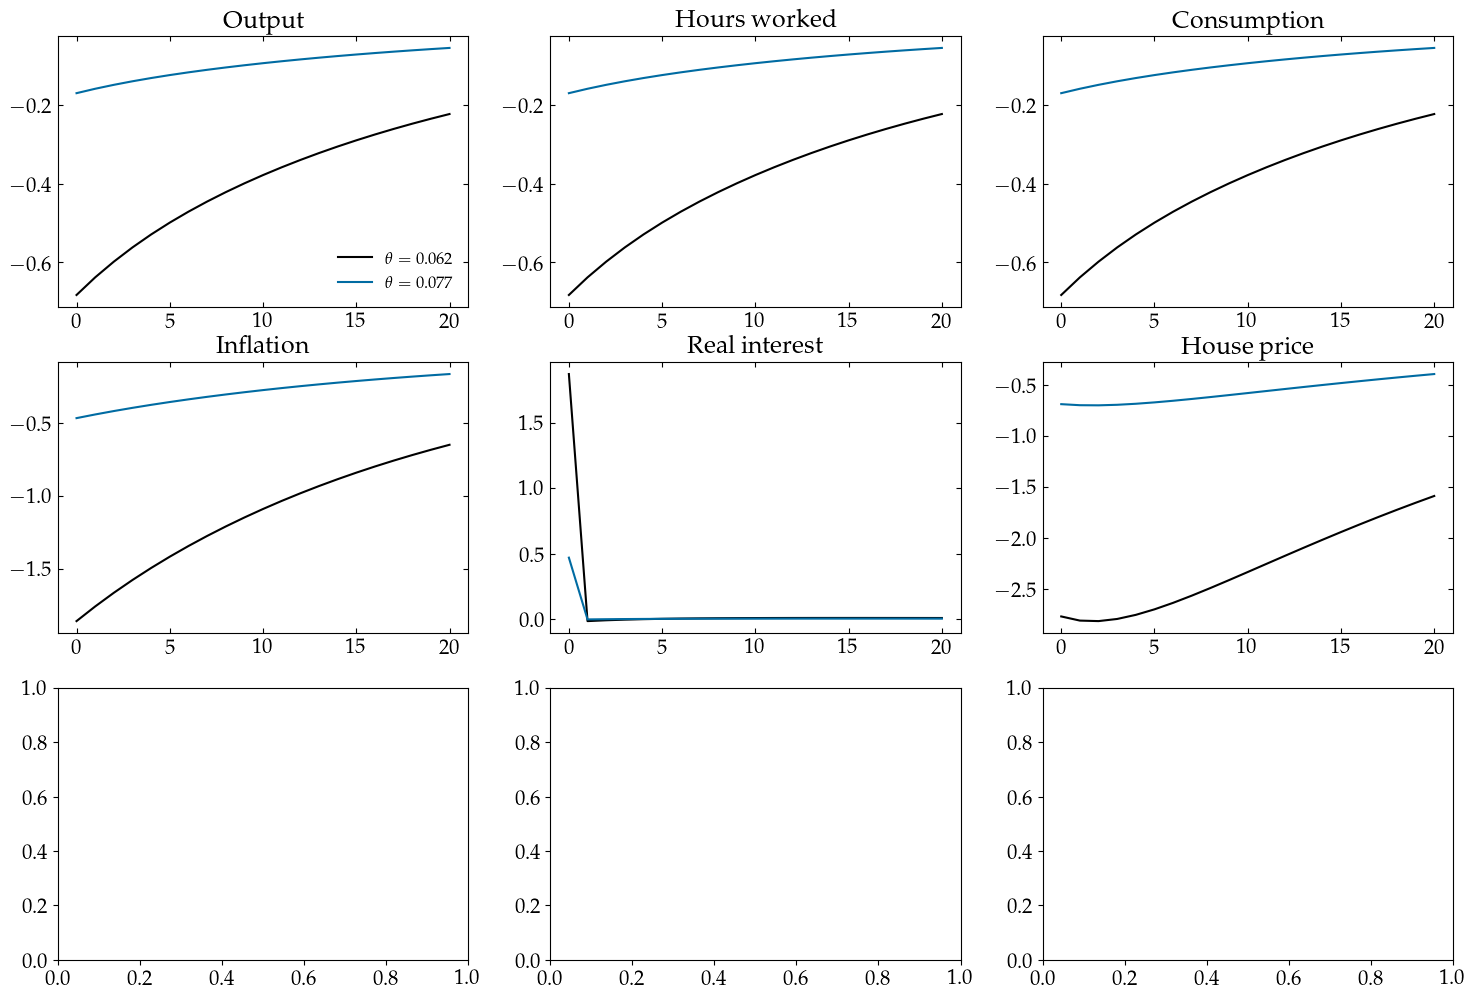

In [79]:
fig, ax = plt.subplots(3, 3, figsize=(18,12))
ax = ax.flatten()

var_name = {'Y': 'Output', 'N': 'Hours worked', 'C_BHAT': 'Consumption', 
            'pi': 'Inflation', 'r': 'Real interest', 'qh': 'House price', 'N': 'Hours worked'}

for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*irf_B[key][:21], label = fr"$\theta = $ {ss['theta']:0.3f}")
    ax[i].plot(100*irf_linear[key][:21], label = fr"$\theta =$ {ss_lg['theta']:0.3f}")
    # ax[i].plot(100*irf_linear[key][:21], label = fr"Linear IRF")
    ax[i].set_title(var_name[key])
    if i == 0:
        ax[i].legend(fontsize=12, frameon=False)
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)

plt.show()

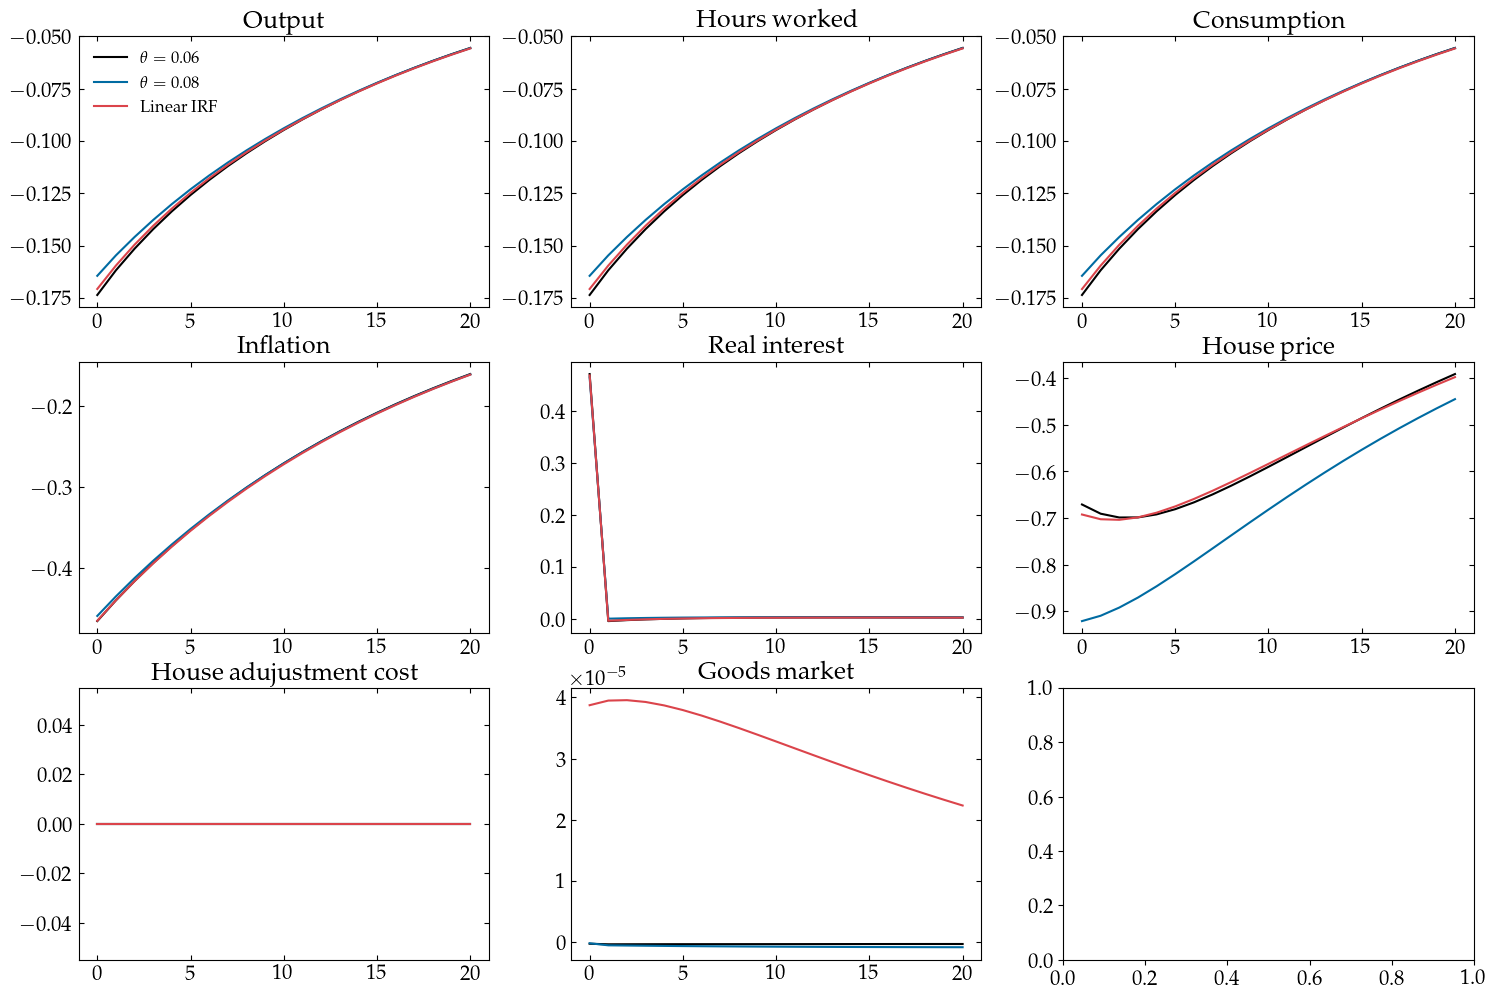

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(18,12))
ax = ax.flatten()

var_name = {'Y': 'Output', 'N': 'Hours worked', 'C_BHAT': 'Consumption', 
            'pi': 'Inflation', 'r': 'Real interest', 'qh': 'House price', 'CHI': 'House adujustment cost',
            'goods_mkt': 'Goods market', 'N': 'Hours worked'}

for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*irf[key][:21], label = fr"$\theta = $ {ss['theta']:0.3f}")
    ax[i].plot(100*ifr_lg[key][:21], label = fr"$\theta =$ {ss_lg['theta']:0.3f}")
    ax[i].plot(100*irf_linear[key][:21], label = fr"Linear IRF")
    ax[i].set_title(var_name[key])
    if i == 0:
        ax[i].legend(fontsize=12, frameon=False)
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)

plt.show()